**MÁSTER EN CIENCIA DE DATOS**

**TRABAJO FIN DE MÁSTER**

**USO DE ALGORITMOS DE MACHINE LEARNING PARA IDENTIFICAR ANOMALÍAS EN TRANSFERENCIAS FINANCIERAS DIGITALES**

In [ ]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.ensemble import VotingClassifier

In [ ]:
# conectar con drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cargar los datos
df = pd.read_csv('/content/drive/MyDrive/Master/creditcard.csv')

## Análisis exploratorio de datos

Comenzaremos revisando los datos faltantes y visualizando las relaciones entre las variables con diferentes gráficas.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Carga y Estructura del Dataset:

Se ha cargado el conjunto de datos `creditcard.csv`, compuesto por **284,807 registros** y **31 columnas**, donde:

* 30 variables (V1 a V28, `Time` y `Amount`) representan características numéricas.
* La columna `Class` es la variable objetivo, indicando si una transacción es fraudulenta (`1`) o legítima (`0`).

In [ ]:
df.isnull().sum().sum()

np.int64(0)

No se detectaron valores faltantes.

In [ ]:
df.duplicated().sum()

np.int64(1081)

In [ ]:
# mostrar los datos duplicados
df[df.duplicated()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,...,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,...,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,...,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,...,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


In [ ]:
df['Class'].value_counts()
df[df.duplicated()]['Class'].value_counts()

,count
Class,
0,1062
1,19


### Duplicados:

Se identificaron **1,081 registros duplicados**, distribuidos de la siguiente manera:
* **1,062** transacciones legítimas (`Class = 0`)
* **19** transacciones fraudulentas (`Class = 1`)

**Decisión**: No se eliminaron los duplicados.

Cuando los datos están anonimizados, no hay forma de verificar si los registros duplicados son:
- Transacciones legítimamente repetidas (como dos cargos iguales en diferentes días),
- O errores en la recolección o preprocesamiento de datos.

En este caso: no es recomendable usar drop_duplicates() a ciegas, porque se podrían eliminar transacciones válidas de la clase minoritaria (fraudes), lo cual es crítico ya que ya son pocas.

En contextos donde los datos están anonimizados, eliminar duplicados puede resultar riesgoso, especialmente si se eliminan casos positivos (fraudes), ya que la clase minoritaria es extremadamente escasa y valiosa para el entrenamiento del modelo.

In [ ]:
df['Class'].describe()

,Class
count,284807.000000
mean,0.001727
std,0.041527
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [ ]:
df['Class'].value_counts(normalize=True)*100

,proportion
Class,
0,99.827251
1,0.172749


### Distribución de la Variable Objetivo

* **Transacciones legítimas (Clase 0)**: 284,315 (≈ 99.83%)
* **Transacciones fraudulentas (Clase 1)**: 492 (≈ 0.17%)

Esto refleja un **fuerte desbalance de clases**, típico en problemas de detección de fraude. El tratamiento de este desbalance será una parte central del preprocesamiento y modelado, utilizando técnicas como **SMOTE** para aumentar la representatividad de la clase minoritaria durante el entrenamiento.

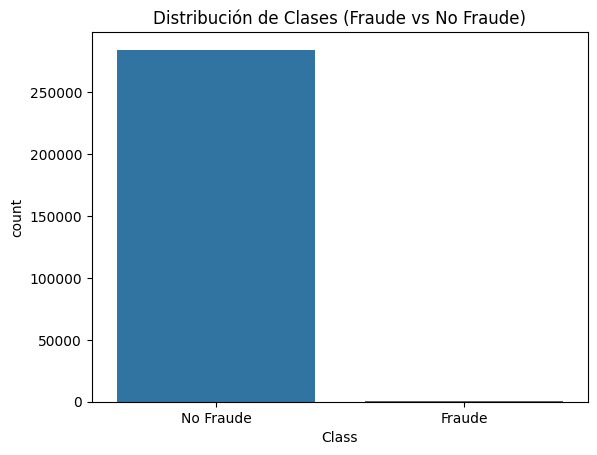

In [ ]:
# Visualización de la distribución de clases (fraude vs no fraude)
sns.countplot(x='Class', data=df)
plt.title("Distribución de Clases (Fraude vs No Fraude)")
plt.xticks([0, 1], ['No Fraude', 'Fraude'])
plt.show()

### Visualización del Desbalance de Clases

La visualización refuerza el hallazgo cuantitativo previo: el conjunto de datos presenta un **fuerte desbalance de clases**, con una gran mayoría de transacciones correspondientes a la clase **"No Fraude"** (`Class = 0`), y una proporción mínima etiquetada como **"Fraude"** (`Class = 1`).

Este desequilibrio plantea un desafío importante para los algoritmos de clasificación, ya que estos tienden a favorecer la clase mayoritaria, comprometiendo la **capacidad de detección de fraudes reales**. Como resultado, métricas como la **precisión global** pueden ser engañosamente altas, mientras que la **recall** (sensibilidad) para la clase minoritaria puede ser extremadamente baja.

### Estrategia para Abordar el Desbalance

Para mitigar este problema, se optó por utilizar la técnica **SMOTE** (*Synthetic Minority Over-sampling Technique*), que genera muestras sintéticas de la clase minoritaria mediante interpolación. Se aplicaron dos configuraciones:

* **SMOTE 90%-10%**: Aumenta la clase minoritaria hasta representar aproximadamente el 10% del conjunto de entrenamiento.
* **SMOTE 95%-5%**: Aumenta la clase minoritaria hasta representar un 5%.

Estas variantes se probarán con distintos modelos de clasificación para evaluar cuál combinación ofrece un mejor equilibrio entre **precisión** y **recall**, centrándonos en la capacidad del modelo para identificar correctamente las transacciones fraudulentas sin incurrir en un número excesivo de falsos positivos.

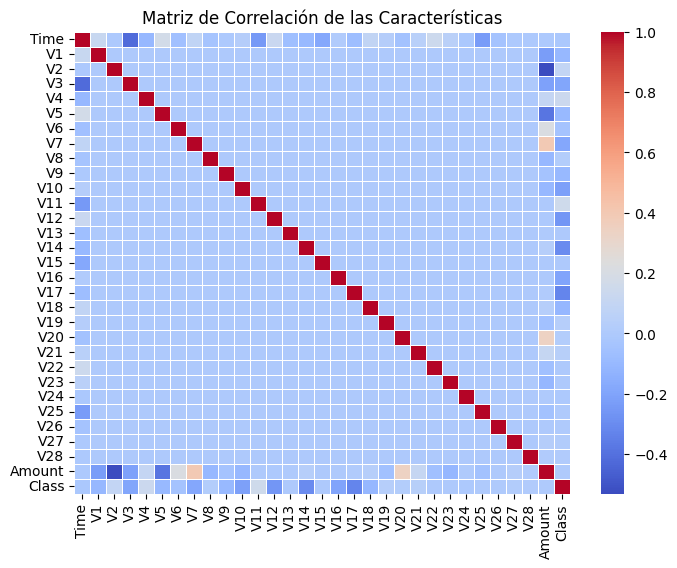

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear un heatmap para visualizar la correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlación de las Características")
plt.show()

### Análisis de Correlación entre las Características

La **matriz de correlación** permite examinar la relación lineal entre las distintas variables del conjunto de datos. Las características `V1` a `V28` han sido previamente transformadas mediante un algoritmo de reducción de dimensionalidad (probablemente PCA), lo cual explica su baja correlación entre sí y con otras variables originales como `Time` y `Amount`.

En relación a la variable objetivo (`Class`), se observa que **no existe una correlación fuerte con ninguna de las características**. Este resultado sugiere que la **detección de fraude no puede basarse únicamente en relaciones lineales** entre variables, lo que justifica el uso de modelos de aprendizaje automático que puedan capturar patrones no lineales y complejos.

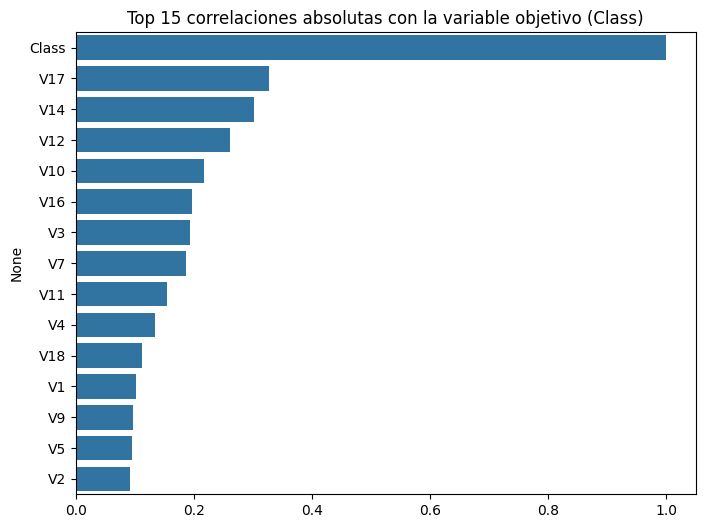

In [ ]:
# Vizualizar las correlaciones absolutas con la variable objetivo (Class)
plt.figure(figsize=(8, 6))
cor_target = abs(df.corr()['Class']).sort_values(ascending=False)
sns.barplot(x=cor_target.values[:15], y=cor_target.index[:15])
plt.title('Top 15 correlaciones absolutas con la variable objetivo (Class)')
plt.show()

### Variables Más Correlacionadas con la Variable Objetivo

El gráfico anterior muestra las 15 variables con mayor **correlación absoluta** con la variable objetivo `Class`, la cual indica si una transacción es fraudulenta (1) o no (0). Aunque los valores de correlación no son particularmente altos, se destacan algunas variables:

* `V17`, `V14`, `V12` y `V10` presentan **las correlaciones más fuertes** (aunque moderadas) con la clase.
* La mayoría de las variables altamente correlacionadas provienen del grupo `V1` a `V28`, transformadas mediante **PCA**, lo que explica sus características latentes y no interpretables directamente.

Este análisis ayuda a identificar qué variables pueden aportar mayor valor predictivo a los modelos, aunque **el bajo nivel de correlación lineal sugiere que se requieren modelos capaces de capturar relaciones no lineales** para una detección de fraude efectiva.

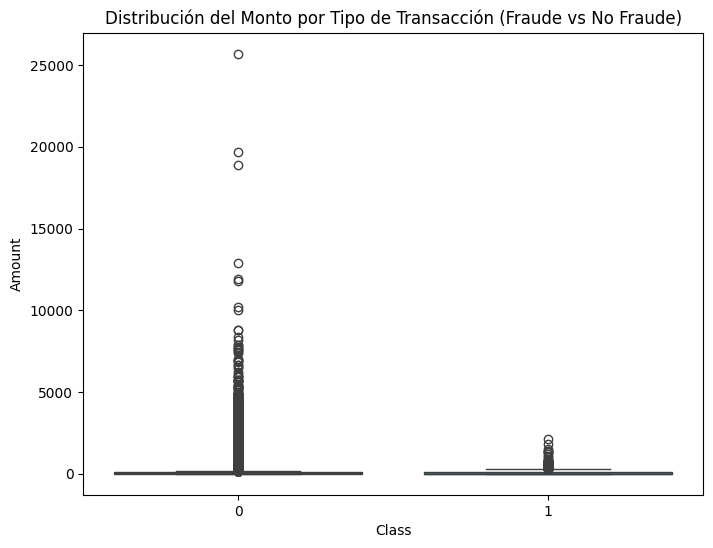

In [ ]:
# Boxplot para ver la distribución del monto para las transacciones fraudulentas y no fraudulentas
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribución del Monto por Tipo de Transacción (Fraude vs No Fraude)')
plt.show()

### Distribución del Monto por Tipo de Transacción

El **boxplot** permite comparar visualmente la distribución del monto (`Amount`) entre las clases `0` (No Fraude) y `1` (Fraude). A partir del gráfico, se destacan los siguientes hallazgos:

* Las transacciones **fraudulentas** tienden a involucrar montos **considerablemente más bajos** que las no fraudulentas.
* En la clase **No Fraude** se observa una mayor dispersión, con **valores atípicos (outliers)** que alcanzan montos muy elevados.
* Esta asimetría y presencia de outliers puede **distorsionar el aprendizaje de los modelos**, sobre todo aquellos sensibles a escalas o distribuciones no normales, como regresión logística o redes neuronales.

Dado lo anterior, se decidió aplicar técnicas de **transformación de variables**, como:

* **Transformación logarítmica** del monto para reducir el impacto de los valores extremos.
* **Normalización o estandarización** con `StandardScaler`.

Estas estrategias ayudan a **estabilizar la varianza** y **mejorar el rendimiento de los modelos predictivos**, especialmente en contextos donde el rango de valores de entrada afecta la convergencia y sensibilidad a patrones relevantes.

In [ ]:
# Mostrar cómo mejora la asimetría
print(f"Skewness original: {df['Amount'].skew()}")

Skewness original: 16.977724453761024


<Axes: >

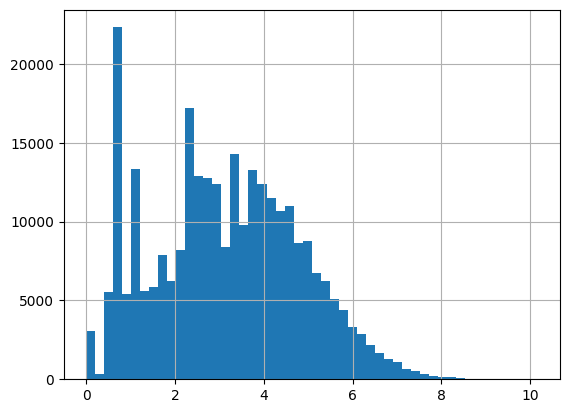

In [ ]:
# Aplicar logaritmo solo si el valor es mayor a 0
df['Amount'] = np.log1p(df['Amount'])

# Revisar cómo se ve después de la transformación
df['Amount'].hist(bins=50)

### Transformación Logarítmica de la Variable `Amount`

La variable `Amount` presentaba inicialmente una **distribución altamente asimétrica hacia la derecha** (*skewness ≈ 16.98*), caracterizada por una **cola larga de valores extremos**. Esta asimetría no solo distorsiona la visualización, sino que también puede comprometer el rendimiento de algunos modelos de aprendizaje automático, especialmente aquellos que asumen distribuciones normales o sensibles a la escala.

Para mitigar este problema, se aplicó la transformación:

La función `log1p()` permite calcular `log(1 + x)`, lo que evita problemas cuando `x = 0` y conserva información de escala relativa.

Previamente, se había utilizado el rango intercuartílico (IQR) para eliminar valores fuera de los umbrales establecidos, pero, al recalcular el IQR sobre los datos filtrados, continuaban identificándose otros valores como atípicos. Además, dado que la variable Amount presentaba una distribución sesgada hacia la derecha (cola larga), algunos valores que en apariencia parecen ser "atípicos" podrían en realidad ser parte de la tendencia normal, lo que resalta la importancia de realizar transformaciones adecuadas para manejar distribuciones asimétricas.

In [ ]:
print(f"Skewness log-transformada: {df['Amount'].skew()}")

Skewness log-transformada: 0.1627029277416401


Tras la transformación:

* La **asimetría se redujo drásticamente a 0.16**, lo que indica una distribución casi simétrica.
* Se facilita la **visualización**, especialmente en técnicas como boxplots.
* Se **reduce el impacto de valores atípicos**, estabilizando la varianza y favoreciendo el entrenamiento de modelos más robustos.

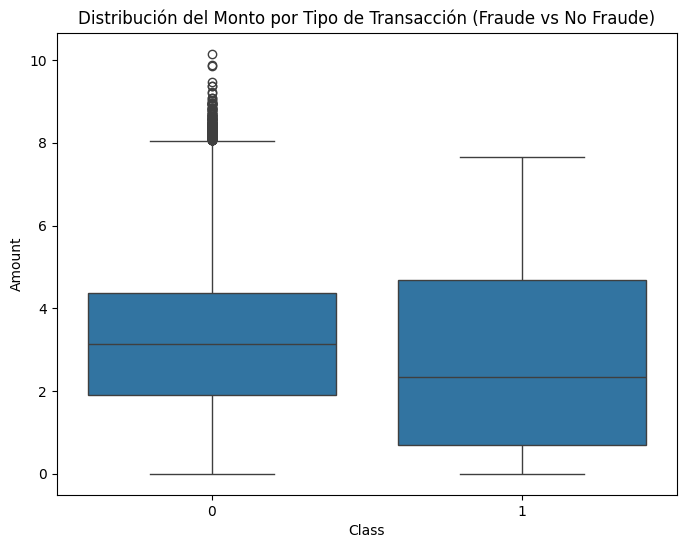

In [ ]:
# Boxplot para ver la distribución del monto para las transacciones fraudulentas y no fraudulentas
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribución del Monto por Tipo de Transacción (Fraude vs No Fraude)')
plt.show()

### Boxplot del Monto por Clase Tras la Transformación

El nuevo boxplot muestra que la distribución de los montos entre transacciones fraudulentas y no fraudulentas es ahora **más comparable**, aunque siguen existiendo diferencias significativas en las medianas. La reducción de ruido visual facilita un análisis más estable de los patrones relacionados con la clase `Fraude`.

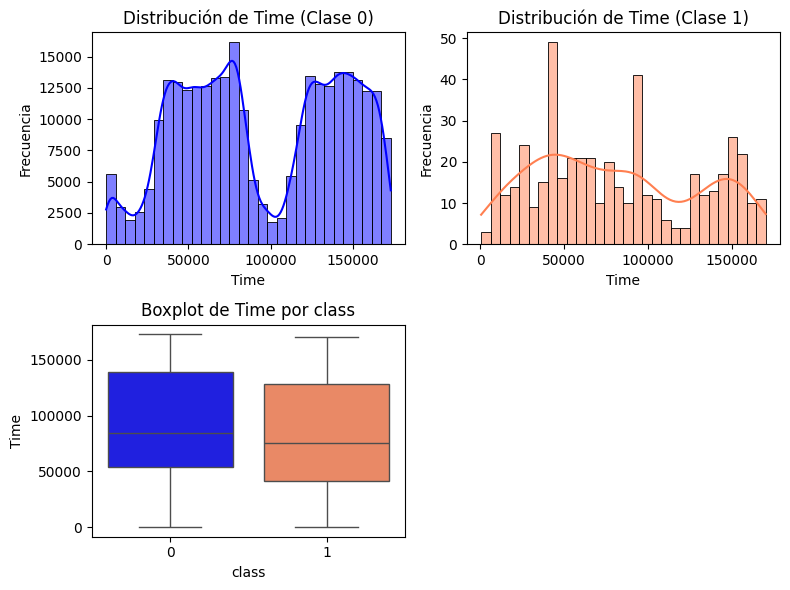

In [ ]:
# Filtrar los datos por clase
df_class_0 = df[df['Class'] == 0]
df_class_1 = df[df['Class'] == 1]

# Histograma para 'Time' de la clase 0
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
sns.histplot(df_class_0['Time'], kde=True, color='blue', bins=30)
plt.title('Distribución de Time (Clase 0)')
plt.xlabel('Time')
plt.ylabel('Frecuencia')

# Histograma para 'Time' de la clase 1
plt.subplot(2, 2, 2)
sns.histplot(df_class_1['Time'], kde=True, color='coral', bins=30)
plt.title('Distribución de Time (Clase 1)')
plt.xlabel('Time')
plt.ylabel('Frecuencia')

# Boxplot para 'Time' comparado por 'class'
plt.subplot(2, 2, 3)
sns.boxplot(x='Class', y='Time', data=df, palette=['blue','coral'])
plt.title('Boxplot de Time por class')
plt.xlabel('class')
plt.ylabel('Time')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

### Análisis Temporal de la Variable **Time**

La variable `Time` representa el tiempo transcurrido en segundos desde la primera transacción registrada. Un día completo equivale a 86,400 segundos, lo que permite una interpretación temporal relativa del comportamiento de los usuarios.

A partir de la visualización se observan los siguientes aspectos:

* La **distribución de `Time` en ambas clases es multimodal**, lo cual indica que las transacciones (fraudulentas o no) se concentran en **ciertos intervalos temporales**, posiblemente asociados a **franjas horarias con mayor actividad**.
* En la clase `0` (no fraude), se identifica una actividad regular con picos bien definidos, probablemente relacionados con horarios de uso frecuente.
* La clase `1` (fraude) muestra una **distribución más dispersa** y menos estructurada, aunque también presenta momentos de mayor concentración.
* El **boxplot sugiere que la mediana del tiempo es similar** entre ambas clases, aunque la dispersión de valores fraudulentos parece ligeramente mayor.

**Interpretación clave:** La variable `Time` por sí sola **no presenta un poder discriminativo fuerte**, pero podría adquirir valor predictivo **combinada con otras variables** o si se transforma (por ejemplo, extrayendo hora del día o agrupando en ventanas temporales).


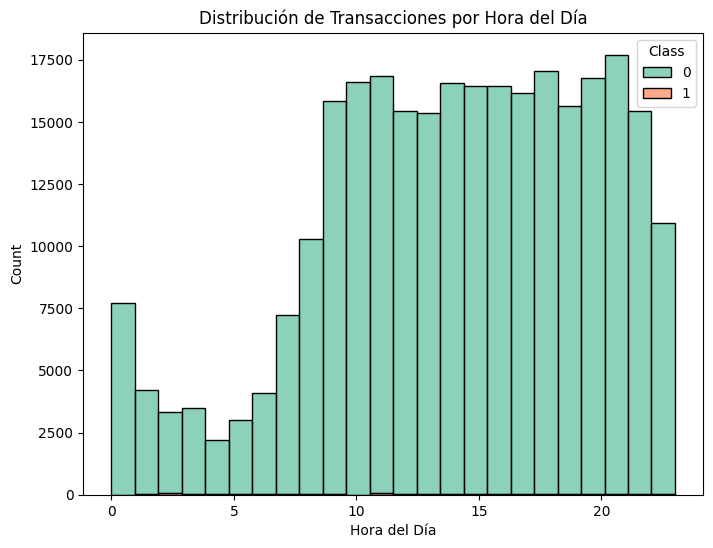

In [ ]:
# Ver la Distribución de Transacciones por Hora del Día
df['Hour'] = (df['Time'] // 3600) % 24

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Hour', hue='Class', multiple='stack', bins=24, palette='Set2')
plt.title("Distribución de Transacciones por Hora del Día")
plt.xlabel("Hora del Día")
plt.show()

### Distribución de Transacciones por Hora del Día

Se ha creado una nueva característica llamada `Hour`, obtenida a partir de la variable `Time` dividiendo los segundos entre 3600 y aplicando el módulo 24 para obtener la **hora del día** (formato de 0 a 23).

A partir del histograma, observamos:

* Existe un **patrón claro de actividad diurna**, con un aumento sostenido de transacciones desde las 7:00 a.m., alcanzando su punto máximo entre las **10:00 a.m. y 9:00 p.m.**
* En cambio, durante las horas de la madrugada (entre las 2:00 a.m. y 6:00 a.m.), la actividad es considerablemente más baja.
* Este patrón se mantiene en ambas clases, aunque el número de **transacciones fraudulentas (Clase 1)** parece **distribuirse de forma proporcional** a lo largo del día, sin concentraciones evidentes en una franja horaria específica.

Aunque el número total de transacciones varía significativamente según la hora del día, la proporción de fraudes por hora no muestra un sesgo evidente. Sin embargo, **la variable `Hour` podría resultar útil como variable contextual**, especialmente si se combina con técnicas más complejas como modelos temporales o ingeniería de interacción.

## Preprocesamiento de los datos

In [ ]:
# Separar las variables predictoras (X) y la variable objetivo (y)
X = df.drop(['Class'], axis=1)
y = df['Class']

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Preprocesamiento y División del Conjunto de Datos

La división del conjunto de datos se realizó asignando un **70% para entrenamiento** y un **30% para prueba**, sin aplicar **estratificación (`stratify=y`)**. Aunque el uso de estratificación es una práctica común en problemas con desbalance de clases, la decisión de **no emplearla en este caso está justificada tanto teóricamente como empíricamente** por las siguientes razones:

1. **Propósito del modelo**: El conjunto no busca representar una muestra de una población humana con sesgos conocidos, sino detectar patrones anómalos en transacciones financieras. Por tanto, la proporción exacta de clases en los subconjuntos **no es crítica** siempre que haya suficientes casos positivos para entrenar y evaluar.

2. **Evaluación empírica**: Se realizaron pruebas en un *notebook paralelo* utilizando `stratify=y`, y **los resultados no mostraron mejoras significativas en las métricas de desempeño** (como `F1-score`, `Recall` o `Precision`). Esto indica que el modelo mantiene su capacidad de generalización incluso sin aplicar esta técnica.

3. **Preservación de casos positivos**: Al utilizar una proporción de **30% para el conjunto de prueba**, se asegura un volumen razonable de casos de fraude (`Class = 1`) tanto en entrenamiento como en validación. Esto evita que el modelo se enfrente a conjuntos con muy pocos o ningún ejemplo positivo.

4. **Simplicidad y reproducibilidad**: No usar estratificación reduce la complejidad y facilita la comparación entre diferentes configuraciones de modelos, sobre todo al aplicar técnicas de balanceo como **SMOTE**, que intervienen posteriormente en el pipeline.

**Nota metodológica**: La decisión fue discutida con el tutor académico y se optó por mantener la versión sin estratificación tras verificar que no afectaba negativamente el rendimiento ni la representatividad de los conjuntos.

### Escalado de Variables Numéricas

El escalado se aplicó a todas las variables para garantizar homogeneidad en la escala de entrada, aunque las variables V1-V28 ya se encontraban aproximadamente normalizadas por técnicas previas como PCA. Este enfoque uniforme favorece la compatibilidad del pipeline y mejora la estabilidad de ciertos algoritmos sensibles a diferencias de magnitud.

In [ ]:
# Guardar columnas e índices ANTES del escalado
X_train_columns = X_train.columns
X_test_columns = X_test.columns
X_train_index = X_train.index
X_test_index = X_test.index

# Escalar todo el conjunto
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reconstruir los DataFrames con los índices y columnas originales
X_train = pd.DataFrame(X_train_scaled, columns=X_train_columns, index=X_train_index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_columns, index=X_test_index)

# Verificar columnas escaladas
pd.options.display.max_columns = None
X_train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Hour
count,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05,1.993640e+05
mean,4.961154e-17,-8.197309e-18,-9.551647e-18,-2.605319e-17,-2.851238e-19,1.774896e-17,7.399853e-18,-2.017251e-17,1.568181e-18,-1.849741e-17,1.240288e-17,1.806972e-17,-1.354338e-17,1.268801e-17,9.622928e-19,2.056455e-17,4.561981e-18,-9.453636e-18,7.056814e-18,1.318698e-17,-1.040702e-17,-1.568181e-18,-5.452992e-18,-5.167869e-19,-1.136931e-17,-2.138428e-18,7.377578e-18,2.227530e-18,1.425619e-19,-5.328607e-16,-1.477476e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.995781e+00,-2.876462e+01,-4.359636e+01,-3.191173e+01,-4.010575e+00,-8.163584e+01,-1.955772e+01,-3.489288e+01,-6.160903e+01,-1.214196e+01,-2.261893e+01,-4.698336e+00,-1.865542e+01,-5.818946e+00,-2.000985e+01,-4.802995e+00,-1.611293e+01,-2.961053e+01,-1.134294e+01,-8.856255e+00,-6.989011e+01,-4.761414e+01,-1.506990e+01,-7.075084e+01,-4.681501e+00,-1.970826e+01,-5.399686e+00,-2.435177e+01,-4.685587e+01,-1.901619e+00,-2.407669e+00
25%,-8.546126e-01,-4.688766e-01,-3.577491e-01,-5.863857e-01,-5.990291e-01,-4.950237e-01,-5.728155e-01,-4.435799e-01,-1.738857e-01,-5.851729e-01,-4.925043e-01,-7.463342e-01,-4.048852e-01,-6.507089e-01,-4.435681e-01,-6.361145e-01,-5.335708e-01,-5.713180e-01,-5.960921e-01,-5.598278e-01,-2.720072e-01,-3.126281e-01,-7.463006e-01,-2.544317e-01,-5.845906e-01,-6.061560e-01,-6.788286e-01,-1.733605e-01,-1.611502e-01,-7.627576e-01,-6.936900e-01
50%,-2.136640e-01,7.703603e-03,4.123315e-02,1.194779e-01,-1.449057e-02,-4.087581e-02,-2.036179e-01,3.215069e-02,1.968045e-02,-4.592776e-02,-8.539931e-02,-3.215522e-02,1.403456e-01,-1.441589e-02,5.447380e-02,5.332328e-02,7.716395e-02,-7.795043e-02,-5.249159e-03,5.405180e-03,-8.043143e-02,-4.039796e-02,9.446030e-03,-1.650419e-02,6.836843e-02,3.015546e-02,-1.061557e-01,4.461267e-03,3.463711e-02,-1.046132e-02,1.632993e-01
75%,9.375041e-01,6.712016e-01,4.830348e-01,6.776056e-01,5.238153e-01,4.374268e-01,2.964431e-01,4.549876e-01,2.759692e-01,5.447219e-01,4.171444e-01,7.228282e-01,6.187018e-01,6.635191e-01,5.146537e-01,7.093654e-01,5.968924e-01,4.711200e-01,5.981305e-01,5.629590e-01,1.710252e-01,2.548445e-01,7.276665e-01,2.336269e-01,7.257874e-01,6.728365e-01,5.004638e-01,2.263397e-01,2.385556e-01,7.289818e-01,8.488907e-01
max,1.643925e+00,1.252668e+00,1.322642e+01,2.763950e+00,1.191182e+01,2.497738e+01,5.480604e+01,9.659405e+01,1.683654e+01,9.433599e+00,1.402616e+01,1.176561e+01,7.837209e+00,7.159096e+00,1.096431e+01,9.709582e+00,1.974526e+01,1.088913e+01,6.017968e+00,6.865480e+00,5.055474e+01,3.718782e+01,1.448198e+01,3.557250e+01,7.568966e+00,1.439777e+01,7.288801e+00,7.780219e+01,1.027844e+02,4.222680e+00,1.534482e+00


#### Resultados después del escalado:

Ambas variables presentan ahora una **distribución estandarizada**, centrada en 0 y con varianza unitaria. Este paso:

* Mejora la **convergencia de los algoritmos** de entrenamiento.
* Reduce el impacto de valores extremos previamente corregidos en `Amount`.
* Facilita la comparación entre variables al estar en una **misma escala numérica**.

### SMOTE

In [ ]:
# SMOTE (90% 10%)

# Calculamos el número total de muestras en el conjunto de entrenamiento
total_samples = len(y_train)

# Definimos el número de muestras para la clase 1 (fraude) con el 10% de las muestras para la clase 1
class_1_samples = int(0.1 * total_samples)

# Usamos SMOTE para generar la cantidad adecuada de muestras para la clase 1 y ajustamos la clase 0 automáticamente
smote_10 = SMOTE(sampling_strategy={1: class_1_samples}, random_state=42)
X_train_smote_10, y_train_smote_10 = smote_10.fit_resample(X_train, y_train)

# Ver distribución de clases antes y después de SMOTE (90%, 10%)
print(f"Distribución de clases antes de SMOTE: {y_train.value_counts()}")
print(f"Distribución de clases después de SMOTE (90% 10%): {y_train_smote_10.value_counts()}")

Distribución de clases antes de SMOTE: Class
0    199008
1       356
Name: count, dtype: int64
Distribución de clases después de SMOTE (90% 10%): Class
0    199008
1     19936
Name: count, dtype: int64


In [ ]:
# SMOTE (95% 5%)

# Calculamos el número total de muestras en el conjunto de entrenamiento
total_samples = len(y_train)

# Definimos el número de muestras para la clase 1 (fraude) con el 5% de las muestras para la clase 1
class_1_samples = int(0.05 * total_samples)

# Usamos SMOTE para generar la cantidad adecuada de muestras para la clase 1 y ajustamos la clase 0 automáticamente
smote_5 = SMOTE(sampling_strategy={1: class_1_samples}, random_state=42)
X_train_smote_5, y_train_smote_5 = smote_5.fit_resample(X_train, y_train)

# Ver distribución de clases antes y después de SMOTE (95%, 5%)
print(f"Distribución de clases antes de SMOTE: {y_train.value_counts()}")
print(f"Distribución de clases después de SMOTE(95% 5%): {y_train_smote_5.value_counts()}")

Distribución de clases antes de SMOTE: Class
0    199008
1       356
Name: count, dtype: int64
Distribución de clases después de SMOTE(95% 5%): Class
0    199008
1      9968
Name: count, dtype: int64


### Rebalanceo del Conjunto de Entrenamiento con SMOTE

Para abordar el severo desbalance entre clases (fraude vs. no fraude), se aplicó la técnica **SMOTE (Synthetic Minority Over-sampling Technique)**, que genera ejemplos sintéticos de la clase minoritaria (`Class = 1`) mediante interpolación entre instancias reales. Esta técnica es útil para evitar que los modelos se sesguen fuertemente hacia la clase mayoritaria durante el entrenamiento.

#### Distribución Original de Clases en el Conjunto de Entrenamiento:

Clase 0 (No Fraude): 199,008
Clase 1 (Fraude):        356

Se implementaron dos variantes de SMOTE con diferentes proporciones para la clase minoritaria:
* SMOTE con proporción 90% - 10%:
 - Clase 0: 199,008
 - Clase 1:  19,936  → (10% del total)

* y SMOTE con proporción 95% - 5%:
 - Clase 0: 199,008
 - Clase 1:   9,968  → (5% del total)

### Consideraciones y Decisión Metodológica

* Inicialmente se probó SMOTE con la configuración predeterminada (balance total 50-50), lo cual resultó en una **generación excesiva de ejemplos sintéticos**, causando **sobreajuste (overfitting)** en varios modelos, especialmente en árboles complejos y redes neuronales.
* Posteriormente se evaluaron las versiones **SMOTE 90-10** y **SMOTE 95-5**, obteniendo resultados más equilibrados y con mejor capacidad de generalización.
* Finalmente, se decidió **comparar los modelos con y sin SMOTE**, con el objetivo de:

  * Evaluar el impacto real del rebalanceo sobre las métricas de interés.
  * Verificar si modelos robustos (como `Random Forest` o `XGBoost`) pueden aprender de manera efectiva **incluso en presencia de desbalance**, sin requerir intervención artificial.

**Nota metodológica**: Esta experimentación y análisis comparativo entre distintas estrategias de SMOTE proporciona una base sólida para justificar el diseño final del pipeline y optimizar el rendimiento sin comprometer la validez de los resultados.

## Modelos

### KNN

In [ ]:
# Modelo KNN sin SMOTE
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Predicciones y evaluación con KNN sin SMOTE
y_pred_knn = model_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.76      0.81       136

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo KNN (90% 10%)
model_knn_smote_10 = KNeighborsClassifier(n_neighbors=5)
model_knn_smote_10.fit(X_train_smote_10, y_train_smote_10)

# Predicciones y evaluación con KNN (90% 10%)
y_pred_knn_smote_10 = model_knn_smote_10.predict(X_test)
print(classification_report(y_test, y_pred_knn_smote_10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.49      0.90      0.63       136

    accuracy                           1.00     85443
   macro avg       0.74      0.95      0.82     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo KNN (95% 5%)
model_knn_smote_5 = KNeighborsClassifier(n_neighbors=5)
model_knn_smote_5.fit(X_train_smote_5, y_train_smote_5)

# Predicciones y evaluación con KNN (95% 5%)
y_pred_knn_smote_5 = model_knn_smote_5.predict(X_test)
print(classification_report(y_test, y_pred_knn_smote_5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.54      0.90      0.68       136

    accuracy                           1.00     85443
   macro avg       0.77      0.95      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Guardar los modelo KNN
joblib.dump(model_knn, '/content/drive/MyDrive/Master/model_knn.joblib')
joblib.dump(model_knn_smote_10, '/content/drive/MyDrive/Master/model_knn_smote_10.joblib')
joblib.dump(model_knn_smote_5, '/content/drive/MyDrive/Master/model_knn_smote_5.joblib')

['/content/drive/MyDrive/Master/model_knn_smote_5.joblib']

### Evaluación del Modelo KNN con y sin SMOTE

Se entrenaron tres variantes del modelo **K-Nearest Neighbors (KNN)** con `k = 5`, evaluando su desempeño en la detección de fraudes con distintas estrategias de balanceo aplicadas al conjunto de entrenamiento:

1. **KNN sin SMOTE**
2. **KNN con SMOTE (90%-10%)**
3. **KNN con SMOTE (95%-5%)**

#### Resultados del Modelo KNN — Sin SMOTE

El modelo sin rebalanceo logra una **alta precisión (0.88)**, lo que indica que la mayoría de las predicciones positivas son correctas. Sin embargo, su **recall es limitado (0.76)**, omitiendo aproximadamente el 24% de los fraudes reales. El F1-score fue de **0.81**. Esto evidencia un **buen equilibrio en contextos donde la precisión es prioritaria**, pero con cierta pérdida de sensibilidad.

#### Resultados del Modelo KNN — SMOTE (90%-10%)

Al aplicar SMOTE con una proporción de **90%-10%**, el modelo incrementa el **recall a 0.90**, mejorando su capacidad para detectar fraudes. No obstante, esto causa una caída notable en la **precisión (0.49)** y reduce el F1-score a **0.63**. Este comportamiento sugiere un aumento en los falsos positivos, haciendo que el modelo sea más sensible pero menos confiable.

#### Resultados del Modelo KNN — SMOTE (95%-5%)

La versión con **SMOTE 95%-5%** mantiene un **recall alto (0.90)**, pero mejora la **precisión a 0.54**, y eleva el **F1-score a 0.68**. Esta configuración ofrece un **mejor equilibrio entre detección de fraudes y reducción de falsos positivos**, resultando en una alternativa más robusta que la anterior.

### Conclusión Comparativa

El uso de **SMOTE permite aumentar significativamente el recall**, favoreciendo la detección de fraudes. Sin embargo, esto se logra a costa de la **precisión**, especialmente en la variante 90%-10%. La configuración **SMOTE 95%-5%** logra el **mejor equilibrio entre sensibilidad y precisión**, siendo preferible para contextos donde ambos aspectos son críticos. El **modelo sin SMOTE**, aunque menos sensible, ofrece **predicciones más confiables**, y es adecuado cuando se busca minimizar los falsos positivos.

### Random Forest

In [ ]:
# Modelo Random Forest sin SMOTE
model_rf = RandomForestClassifier(n_estimators=100,
                                  max_depth=6,
                                  min_samples_split=8,
                                  min_samples_leaf=3,
                                  class_weight='balanced',
                                  random_state=42)
model_rf.fit(X_train, y_train)

# Predicciones y evaluación con Random Forest sin SMOTE
y_pred_rf = model_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.55      0.89      0.68       136

    accuracy                           1.00     85443
   macro avg       0.77      0.94      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo Random Forest con SMOTE (90% 10%)
model_rf_smote_10 = RandomForestClassifier(n_estimators=100,
                                           max_depth=6,
                                           min_samples_split=8,
                                           min_samples_leaf=3,
                                           random_state=42)
model_rf_smote_10.fit(X_train_smote_10, y_train_smote_10)

# Predicciones y evaluación con Random Forest (90% 10%)
y_pred_rf_smote_10 = model_rf_smote_10.predict(X_test)
print(classification_report(y_test, y_pred_rf_smote_10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.75      0.88      0.81       136

    accuracy                           1.00     85443
   macro avg       0.87      0.94      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo Random Forest con SMOTE (95% 5%)
model_rf_smote_5 = RandomForestClassifier(n_estimators=100,
                                          max_depth=6,
                                          min_samples_split=8,
                                          min_samples_leaf=3,
                                          random_state=42)
model_rf_smote_5.fit(X_train_smote_5, y_train_smote_5)

# Predicciones y evaluación con Random Forest (95% 5%)
y_pred_rf_smote_5 = model_rf_smote_5.predict(X_test)
print(classification_report(y_test, y_pred_rf_smote_5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.80      0.87      0.83       136

    accuracy                           1.00     85443
   macro avg       0.90      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Guardar los modelos Random Forest
joblib.dump(model_rf, '/content/drive/MyDrive/Master/model_rf.joblib')
joblib.dump(model_rf_smote_10, '/content/drive/MyDrive/Master/model_rf_smote_10.joblib')
joblib.dump(model_rf_smote_5, '/content/drive/MyDrive/Master/model_rf_smote_5.joblib')

['/content/drive/MyDrive/Master/model_rf_smote_5.joblib']

### Evaluación del Modelo Random Forest con y sin SMOTE

Se entrenaron tres variantes del modelo **Random Forest** con los siguientes hiperparámetros:

```python
n_estimators=100,
max_depth=6,
min_samples_split=8,
min_samples_leaf=3,
random_state=42
```

Esta configuración permite que los árboles capturen interacciones complejas y patrones relevantes, particularmente en la clase minoritaria, mientras se mantiene una **regularización moderada** para mitigar el sobreajuste.

Los modelos fueron entrenados bajo tres configuraciones distintas del conjunto de entrenamiento:

1. Random Forest sin SMOTE (`class_weight='balanced'`)
2. Random Forest con SMOTE (90%-10%)
3. Random Forest con SMOTE (95%-5%)

#### Resultados del Modelo Random Forest — Sin SMOTE

El modelo entrenado sin técnicas de rebalanceo, pero con ponderación automática de clases, alcanza un **recall de 0.89**, una **precisión de 0.55** y un *F1-score* de **0.68**. Aunque logra una buena capacidad para identificar fraudes, presenta una mayor proporción de falsos positivos. No obstante, constituye una alternativa válida cuando no se desea generar instancias sintéticas.

#### Resultados del Modelo Random Forest — SMOTE (90%-10%)

Al aplicar **SMOTE (90%-10%)**, el modelo mejora sustancialmente: obtiene una **precisión de 0.75**, un **recall de 0.88** y un *F1-score* de **0.81**. Esta configuración demuestra un mejor equilibrio entre sensibilidad y confiabilidad en las predicciones, superando claramente a la variante sin SMOTE.

#### Resultados del Modelo Random Forest — SMOTE (95%-5%)

La versión con **SMOTE (95%-5%)** logra el mejor rendimiento general: **precisión de 0.80**, **recall de 0.87** y un *F1-score* de **0.83**. Esta proporción de rebalanceo permite mejorar la capacidad del modelo para detectar fraudes sin comprometer la precisión, posicionándose como la opción más robusta.

### Conclusión Comparativa

El uso de **SMOTE mejora significativamente el desempeño del modelo Random Forest**, en especial en cuanto al *F1-score*, que refleja el balance entre precisión y sensibilidad. La configuración **SMOTE (95%-5%)** destaca como la más eficaz, optimizando la detección de fraudes sin incurrir en un aumento excesivo de falsos positivos. Si bien la versión sin SMOTE ofrece un rendimiento aceptable, la incorporación de técnicas de rebalanceo permite un salto cualitativo en la calidad del modelo.

En resumen, **SMOTE (95%-5%) se consolida como la alternativa más adecuada** para abordar eficazmente problemas de clasificación de fraudes con alto desbalance de clases.

In [ ]:
# Mostrar las características más importantes de Random Forest sin SMOTE
feature_importances_rf = pd.DataFrame(model_rf.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("Random Forest sin SMOTE")
feature_importances_rf.head()

Random Forest sin SMOTE


,Importance
V14,0.201721
V10,0.149738
V12,0.113682
V4,0.096046
V17,0.084019


In [ ]:
# Mostrar las características más importantes
feature_importances_rf_smote_10 = pd.DataFrame(model_rf_smote_10.feature_importances_,
                                   index=X_train_smote_10.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("Random Forest SMOTE (90%-10%)")
feature_importances_rf_smote_10.head()

Random Forest SMOTE (90%-10%)


,Importance
V14,0.251772
V10,0.171854
V12,0.113767
V17,0.102438
V11,0.098322


In [ ]:
# Mostrar las características más importantes
feature_importances_rf_smote_5 = pd.DataFrame(model_rf_smote_5.feature_importances_,
                                   index=X_train_smote_5.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("Random Forest SMOTE (95%-5%)")
feature_importances_rf_smote_5.head()

Random Forest SMOTE (95%-5%)


,Importance
V14,0.231025
V10,0.173126
V12,0.119562
V17,0.115434
V11,0.105721


### Importancia de Variables — Modelo Random Forest

La variable V14 es consistentemente la más relevante en todas las configuraciones. También destacan V10 y V12 como importantes en todos los casos, lo que indica una estabilidad en la capacidad predictiva de estas características frente a variaciones en el rebalanceo.

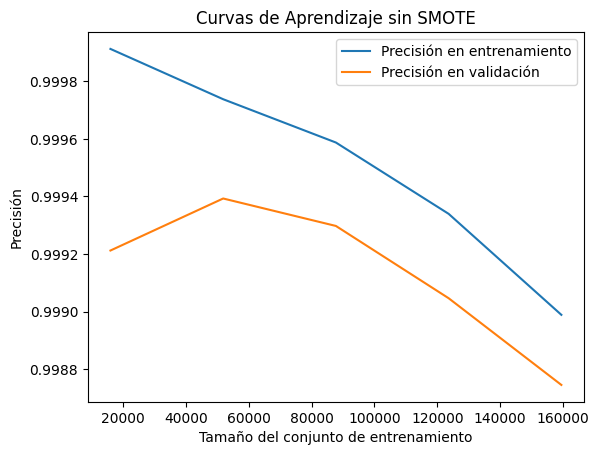

In [ ]:
# Curvas de Aprendizaje sin SMOTE
train_sizes, train_scores, test_scores = learning_curve(model_rf, X_train, y_train, cv=5, n_jobs=-1)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Precisión en entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Precisión en validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curvas de Aprendizaje sin SMOTE')
plt.legend()
plt.show()

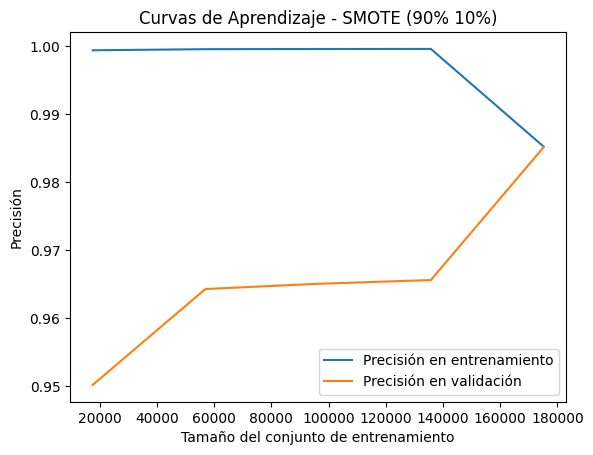

In [ ]:
# Curvas de Aprendizaje - SMOTE (90% 10%)
train_sizes, train_scores, test_scores = learning_curve(model_rf_smote_10, X_train_smote_10, y_train_smote_10, cv=5, n_jobs=-1)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Precisión en entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Precisión en validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curvas de Aprendizaje - SMOTE (90% 10%)')
plt.legend()
plt.show()

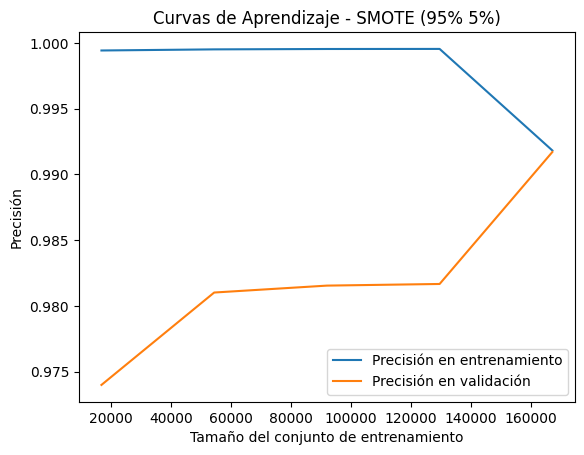

In [ ]:
# Curvas de Aprendizaje - SMOTE (95% 5%)
train_sizes, train_scores, test_scores = learning_curve(model_rf_smote_5, X_train_smote_5, y_train_smote_5, cv=5, n_jobs=-1)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Precisión en entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Precisión en validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curvas de Aprendizaje - SMOTE (95% 5%)')
plt.legend()
plt.show()

### Curvas de Aprendizaje

Las curvas de aprendizaje para los tres modelos de **Random Forest** revelan comportamientos distintos según se haya aplicado o no SMOTE. A medida que se incrementa el tamaño del conjunto de entrenamiento, se observa una evolución en la precisión tanto en entrenamiento como en validación:

* En el modelo **sin SMOTE**, la **precisión en entrenamiento** (línea azul) se mantiene muy alta (≥ 99.8 %) pero decrece levemente al aumentar los datos, mientras que la **precisión en validación** (línea naranja) empieza más baja (\~99.2 %) y también disminuye gradualmente. La **brecha entre ambas curvas permanece constante**, lo que sugiere una **ligera tendencia al sobreajuste**, aunque bien controlada.

* En la variante **SMOTE 90%-10%**, se observa una **precisión en entrenamiento cercana al 100 %**, lo que evidencia una mayor propensión al sobreajuste en las primeras fases del entrenamiento. Sin embargo, la **precisión en validación mejora continuamente**, alcanzando casi el **98 %** en los tramos finales, lo cual indica que el modelo **gana capacidad de generalización** al aumentar los datos.

* En el caso **SMOTE 95%-5%**, el comportamiento es aún más estable. Aunque la curva de entrenamiento también parte del 100 %, la **curva de validación crece con mayor suavidad y se estabiliza por encima del 98.5 %**, mostrando un **mejor balance entre ajuste y generalización** incluso desde tamaños de entrenamiento más reducidos.

Las curvas confirman que **el modelo Random Forest se beneficia del incremento en el tamaño de datos**, y que las versiones con SMOTE, especialmente la de **95%-5%**, muestran una **mejor convergencia y menor brecha entre entrenamiento y validación**, indicando una **capacidad de generalización más robusta**. Estos resultados respaldan el uso de técnicas de rebalanceo como SMOTE, especialmente en configuraciones parciales, al evidenciar una mejora progresiva en la capacidad de generalización conforme se incrementa el volumen de datos disponibles.

### XGBoost

In [ ]:
# Calcular el número de clases
negativos = (y_train == 0).sum()
positivos = (y_train == 1).sum()

# Modelo XGBoost sin SMOTE
model_xgb = xgb.XGBClassifier(scale_pos_weight = negativos / positivos,
                              objective='binary:logistic',
                              eval_metric='logloss',
                              max_depth=4,
                              learning_rate=0.1,
                              n_estimators=100,
                              reg_alpha=0.1,
                              reg_lambda=0.1,
                              use_label_encoder=False,
                              random_state=42)

model_xgb.fit(X_train, y_train)

# Predicciones y evaluación con XGBoost sin SMOTE
y_pred_xgb = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.37      0.90      0.53       136

    accuracy                           1.00     85443
   macro avg       0.69      0.95      0.76     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo XGBoost con SMOTE (90% 10%)
model_xgb_smote_10 = xgb.XGBClassifier(objective='binary:logistic',
                                       eval_metric='logloss',
                                       max_depth=4,
                                       learning_rate=0.1,
                                       n_estimators=100,
                                       reg_alpha=0.1,
                                       reg_lambda=0.1,
                                       use_label_encoder=False,
                                       random_state=42)
model_xgb_smote_10.fit(X_train_smote_10, y_train_smote_10)

# Predicciones y evaluación con XGBoost (90% 10%)
y_pred_xgb_smote_10 = model_xgb_smote_10.predict(X_test)
print(classification_report(y_test, y_pred_xgb_smote_10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.64      0.88      0.74       136

    accuracy                           1.00     85443
   macro avg       0.82      0.94      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo XGBoost con SMOTE (95% 5%)
model_xgb_smote_5 = xgb.XGBClassifier(objective='binary:logistic',
                                      eval_metric='logloss',
                                      max_depth=4,
                                      learning_rate=0.1,
                                      n_estimators=100,
                                      reg_alpha=0.1,
                                      reg_lambda=0.1,
                                      use_label_encoder=False,
                                      random_state=42)
model_xgb_smote_5.fit(X_train_smote_5, y_train_smote_5)

# Predicciones y evaluación con XGBoost (95% 5%)
y_pred_xgb_smote_5 = model_xgb_smote_5.predict(X_test)
print(classification_report(y_test, y_pred_xgb_smote_5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.77      0.88      0.82       136

    accuracy                           1.00     85443
   macro avg       0.88      0.94      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Guardar los modelos XGBoost
joblib.dump(model_xgb, '/content/drive/MyDrive/Master/model_xgb.joblib')
joblib.dump(model_xgb_smote_10, '/content/drive/MyDrive/Master/model_xgb_smote_10.joblib')
joblib.dump(model_xgb_smote_5, '/content/drive/MyDrive/Master/model_xgb_smote_5.joblib')

['/content/drive/MyDrive/Master/model_xgb_smote_5.joblib']

### Evaluación del Modelo XGBoost con y sin SMOTE

Se entrenaron tres versiones del modelo **XGBoost**, configuradas con los siguientes hiperparámetros:

```python
max_depth = 4  
learning_rate = 0.1  
n_estimators = 100  
reg_alpha = 0.1  
reg_lambda = 0.1  
```

XGBoost permite ajustar el desbalance de clases mediante el parámetro `scale_pos_weight`, que pondera internamente la clase minoritaria sin necesidad de alterar el conjunto de datos. Además, se exploró el efecto de aplicar **SMOTE** con dos proporciones distintas para observar su impacto en el rendimiento.

Las configuraciones evaluadas fueron:

1. Modelo XGBoost sin SMOTE (con `scale_pos_weight`)
2. Modelo XGBoost con SMOTE (90%-10%)
3. Modelo XGBoost con SMOTE (95%-5%)

#### Resultados del Modelo XGBoost — Sin SMOTE

El modelo logra un **recall elevado (0.90)**, lo que indica una gran capacidad para detectar fraudes. Sin embargo, su **precisión es baja (0.37)**, generando muchos falsos positivos. Esto se traduce en un **F1-score moderado de 0.53**, confirmando que el rebalanceo interno con `scale_pos_weight` no es suficiente para mantener un equilibrio entre exactitud y sensibilidad.

#### Resultados del Modelo XGBoost — SMOTE (90%-10%)

Con SMOTE en proporción 90%-10%, el modelo mantiene un **recall de 0.88**, pero ahora con una **mejor precisión (0.64)**. El **F1-score asciende a 0.74**, lo que representa un **equilibrio más favorable** entre detección de fraudes y minimización de falsos positivos. Este balance es esencial en sistemas donde ambas métricas son críticas.

#### Resultados del Modelo XGBoost — SMOTE (95%-5%)

Esta versión alcanza el **mejor rendimiento general**, con un **recall estable (0.88)** y una **precisión aún mayor (0.77)**, lo que eleva el **F1-score a 0.82**, siendo el más alto entre todas las variantes de XGBoost evaluadas. La mejora sugiere que con menos sobresaturación sintética, el modelo **aprende mejor la frontera entre clases**, reduciendo tanto errores tipo I como tipo II.

### Conclusión Comparativa

* El modelo sin SMOTE muestra una **excelente sensibilidad**, pero a costa de una baja precisión.
* Las versiones con SMOTE mejoran **significativamente el F1-score**, gracias a una representación más balanceada de la clase minoritaria.
* La configuración **SMOTE 95%-5% ofrece el mejor desempeño**, logrando un equilibrio óptimo entre precisión y recall.
* En comparación con KNN y Random Forest, **XGBoost demostró una notable capacidad para adaptarse al desbalance de clases**, especialmente cuando se utiliza **SMOTE 95%-5%**, consolidándose como uno de los modelos más robustos en este experimento.

In [ ]:
# Mostrar las características más importantes de XGBoost sin SMOTE
feature_importances_xgb = pd.DataFrame(model_xgb.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("XGBoost sin SMOTE")
feature_importances_xgb.head()

XGBoost sin SMOTE


,Importance
V14,0.378767
V4,0.048944
V8,0.047751
V20,0.043142
V12,0.036897


In [ ]:
# Mostrar las características más importantes de XGBoost SMOTE (90% 10%)
feature_importances_xgb_smote_10 = pd.DataFrame(model_xgb_smote_10.feature_importances_,
                                   index=X_train_smote_10.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("XGBoost SMOTE (90%-10%)")
feature_importances_xgb_smote_10.head()

XGBoost SMOTE (90%-10%)


,Importance
V14,0.492859
V17,0.046289
V12,0.040527
V4,0.034709
Time,0.030762


In [ ]:
# Mostrar las características más importantes de XGBoost (95% 5%)
feature_importances_xgb_smote_5 = pd.DataFrame(model_xgb_smote_5.feature_importances_,
                                   index=X_train_smote_5.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("XGBoost SMOTE (95%-5%)")
feature_importances_xgb_smote_5.head()

XGBoost SMOTE (95%-5%)


,Importance
V14,0.462085
V17,0.071096
V12,0.037804
V4,0.031533
V8,0.020693


### Importancia de Variables en XGBoost

En las tres configuraciones evaluadas de XGBoost (sin SMOTE, SMOTE 90%-10% y SMOTE 95%-5%), la variable **V14** destaca como la más influyente con diferencia en todas las variantes, confirmando su papel central en la detección de fraudes.

En modelos con SMOTE, se observa un **aumento en la importancia relativa de V17 y V12**, lo que sugiere que el rebalanceo permite al modelo captar mejor patrones asociados a estas variables. Asimismo, **la inclusión de la variable Time** entre las cinco principales en SMOTE 90%-10% sugiere que este atributo gana relevancia cuando la clase minoritaria está más representada.

Finalmente, aunque las variables V4 y V8 mantienen cierta presencia, su importancia disminuye ligeramente en configuraciones rebalanceadas, indicando una redistribución del foco del modelo hacia señales más específicas de la clase positiva.

### Light GBM

In [ ]:
# Modelo LGBM sin SMOTE
model_lgb = lgb.LGBMClassifier(class_weight="balanced",
                               boosting_type="gbdt",
                               learning_rate=0.1,
                               max_depth=5,
                               n_estimators=100,
                               verbose = -1,
                               random_state=42)
model_lgb.fit(X_train, y_train)

# Predicciones y evaluación con LGBM sin SMOTE
y_pred_lgb = model_lgb.predict(X_test)
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.61      0.89      0.73       136

    accuracy                           1.00     85443
   macro avg       0.81      0.94      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Definir parametros para usar grid search con lightgbm
param_grid = {'learning_rate': [0.01, 0.1, 0.2],
              'n_estimators': [100, 200],
              'max_depth': [3, 5, 7]}

In [ ]:
# Grid search a LGBM sin SMOTE
grid_search_1 = GridSearchCV(estimator=model_lgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_1.fit(X_train, y_train)

# Imprimir los mejores parámetros encontrados y el mejor estimador
print("Mejores parámetros encontrados:")
print(grid_search_1.best_params_)
print("Mejor estimador:")
print(grid_search_1.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros encontrados:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Mejor estimador:
LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=7,
               n_estimators=200, random_state=42, verbose=-1)


In [ ]:
# Predicciones y evaluación de los mejores parametros de LGBM sin SMOTE
y_pred_lgb_grid_1 = grid_search_1.predict(X_test)
print(classification_report(y_test, y_pred_lgb_grid_1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.85      0.89       136

    accuracy                           1.00     85443
   macro avg       0.97      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo LGBM con SMOTE (90% 10%)
model_lgb_smote_10 = lgb.LGBMClassifier(boosting_type="gbdt",
                                        learning_rate=0.1,
                                        max_depth=5,
                                        n_estimators=100,
                                        verbose=-1,
                                        random_state=42)
model_lgb_smote_10.fit(X_train_smote_10, y_train_smote_10)

# Predicciones y evaluación de LGBM con SMOTE (90% 10%)
y_pred_lgb_smote_10 = model_lgb_smote_10.predict(X_test)
print(classification_report(y_test, y_pred_lgb_smote_10))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.74      0.87      0.80       136

    accuracy                           1.00     85443
   macro avg       0.87      0.93      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Grid search a LGBM con SMOTE (90% 10%)
grid_search_2 = GridSearchCV(estimator=model_lgb_smote_10, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_2.fit(X_train_smote_10, y_train_smote_10)

# Imprimir los mejores parámetros encontrados y el mejor estimador
print("Mejores parámetros encontrados:")
print(grid_search_2.best_params_)
print("Mejor estimador:")
print(grid_search_2.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros encontrados:
{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Mejor estimador:
LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=200,
               random_state=42, verbose=-1)


In [ ]:
# Predicciones y evaluación de los mejores parametros de LGBM con SMOTE (90% 10%)
y_pred_lgb_grid_2 = grid_search_2.predict(X_test)
print(classification_report(y_test, y_pred_lgb_grid_2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.90      0.84      0.87       136

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Modelo LGBM con SMOTE (95% 5%)
model_lgb_smote_5 = lgb.LGBMClassifier(boosting_type="gbdt",
                                       learning_rate=0.1,
                                       max_depth=5,
                                       n_estimators=100,
                                       verbose = -1,
                                       random_state=42)
model_lgb_smote_5.fit(X_train_smote_5, y_train_smote_5)

# Predicciones y evaluación de LGBM con SMOTE (95% 5%)
y_pred_lgb_smote_5 = model_lgb_smote_5.predict(X_test)
print(classification_report(y_test, y_pred_lgb_smote_5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.86      0.83       136

    accuracy                           1.00     85443
   macro avg       0.90      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Grid search a LGBM con SMOTE (95% 5%)
grid_search_3 = GridSearchCV(estimator=model_lgb_smote_5, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_3.fit(X_train_smote_5, y_train_smote_5)

# Imprimir los mejores parámetros encontrados y el mejor estimador
print("Mejores parámetros encontrados:")
print(grid_search_3.best_params_)
print("Mejor estimador:")
print(grid_search_3.best_estimator_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejores parámetros encontrados:
{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Mejor estimador:
LGBMClassifier(learning_rate=0.2, max_depth=5, n_estimators=200,
               random_state=42, verbose=-1)


In [ ]:
# Predicciones y evaluación de los mejores parametros de LGBM con SMOTE (95% 5%)
y_pred_lgb_grid_3 = grid_search_3.predict(X_test)
print(classification_report(y_test, y_pred_lgb_grid_3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.85      0.89       136

    accuracy                           1.00     85443
   macro avg       0.96      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
# Guardar los models LGBM
joblib.dump(model_lgb, '/content/drive/MyDrive/Master/model_lgb.joblib')
joblib.dump(grid_search_1, '/content/drive/MyDrive/Master/grid_search_1.joblib')
joblib.dump(model_lgb_smote_10, '/content/drive/MyDrive/Master/model_lgb_smote_10.joblib')
joblib.dump(grid_search_2, '/content/drive/MyDrive/Master/grid_search.joblib')
joblib.dump(model_lgb_smote_5, '/content/drive/MyDrive/Master/model_lgb_smote_5.joblib')
joblib.dump(grid_search_3, '/content/drive/MyDrive/Master/grid_search_3.joblib')

['/content/drive/MyDrive/Master/grid_search_3.joblib']

### Evaluación del Modelo LightGBM con y sin SMOTE

Se entrenaron tres variantes del modelo **LightGBM**, utilizando el parámetro `class_weight='balanced'` para mitigar el desbalance de clases. Además, se aplicó ajuste de hiperparámetros mediante **Grid Search** con validación cruzada. Las configuraciones evaluadas fueron:

1. Modelo LightGBM sin SMOTE
2. Modelo LightGBM con SMOTE (90%-10%)
3. Modelo LightGBM con SMOTE (95%-5%)

#### Resultados del Modelo LightGBM — Sin SMOTE

En su versión inicial, sin aplicar técnicas de rebalanceo externo, el modelo logró un desempeño sólido para la clase minoritaria:
**Precisión = 0.61**, **Recall = 0.89**, **F1-score = 0.73**.
Esto demuestra una buena capacidad de detección de fraudes con un equilibrio aceptable entre sensibilidad y especificidad.

Posteriormente, con **ajuste de hiperparámetros** (`learning_rate=0.1`, `max_depth=7`, `n_estimators=200`), el rendimiento mejoró notablemente:
**Precisión = 0.93**, **Recall = 0.85**, **F1-score = 0.89**,
consolidándose como uno de los modelos más **robustos y equilibrados** entre todas las versiones evaluadas.

#### Resultados del Modelo LightGBM — SMOTE (90%-10%)

El modelo base entrenado con SMOTE (90%-10%) logró:
**Precisión = 0.74**, **Recall = 0.87**, **F1-score = 0.80**.
Esto representa un mejor equilibrio inicial respecto al modelo sin SMOTE, aunque aún por debajo del optimizado con Grid Search.

Con el ajuste de hiperparámetros (`learning_rate=0.2`, `max_depth=7`, `n_estimators=200`), el rendimiento se estabilizó en:
**Precisión = 0.90**, **Recall = 0.84**, **F1-score = 0.87**,
lo que posiciona a esta configuración como **altamente balanceada**, adecuada para aplicaciones donde tanto los falsos positivos como los falsos negativos deben minimizarse.

#### Resultados del Modelo LightGBM — SMOTE (95%-5%)

El modelo con SMOTE (95%-5%) mostró métricas iniciales similares al anterior:
**Precisión = 0.81**, **Recall = 0.86**, **F1-score = 0.83**.

Tras ajustar los hiperparámetros con Grid Search, se alcanzó un **excelente rendimiento global**, similar al modelo optimizado sin SMOTE:
**Precisión = 0.92**, **Recall = 0.85**, **F1-score = 0.89**.

### Conclusión Comparativa

* Tanto el modelo **LightGBM sin SMOTE optimizado** como el modelo **con SMOTE 95%-5% optimizado mediante Grid Search** ofrecieron un **rendimiento sobresaliente**, con un **F1-score de 0.89**, destacándose por su precisión, sensibilidad y equilibrio general.
* SMOTE mejora considerablemente el rendimiento inicial, pero **requiere ajuste cuidadoso de hiperparámetros** para alcanzar su máximo potencial.
* En conjunto, **LightGBM se consolida como el modelo más versátil y eficaz del experimento**, capaz de adaptarse eficazmente a contextos desbalanceados con estrategias tanto internas (`class_weight`) como externas (SMOTE).

In [ ]:
# Mostrar las características más importantes de LGBM sin SMOTE
feature_importances_lgb = pd.DataFrame(model_lgb.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM sin SMOTE")
feature_importances_lgb.head()

LightGBM sin SMOTE


,Importance
V14,283
V4,236
Amount,156
V12,155
V10,145


In [ ]:
# Mostrar las características más importantes de Grid search a LGBM sin SMOTE
feature_importances_lgb_grid_1 = pd.DataFrame(grid_search_1.best_estimator_.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM GridSearch 1 (sin SMOTE)")
feature_importances_lgb_grid_1.head()

LightGBM GridSearch 1 (sin SMOTE)


,Importance
V14,311
V26,266
V12,228
Amount,228
V13,227


In [ ]:
# Mostrar las características más importantes de LGBM con SMOTE (90% 10%)
feature_importances_lgb_smote_10 = pd.DataFrame(model_lgb_smote_10.feature_importances_,
                                   index=X_train_smote_10.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM con SMOTE (90%-10%)")
feature_importances_xgb_smote_10.head()

LightGBM con SMOTE (90%-10%)


,Importance
V14,0.492859
V17,0.046289
V12,0.040527
V4,0.034709
Time,0.030762


In [ ]:
# Mostrar las características más importantes de Grid search a LGBM con SMOTE (90% 10%)
feature_importances_lgb_grid_2 = pd.DataFrame(grid_search_2.best_estimator_.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM GridSearch 2 (con SMOTE 90%-10%)")
feature_importances_lgb_grid_2.head()

LightGBM GridSearch 2 (con SMOTE 90%-10%)


,Importance
Hour,511
V14,310
Amount,275
V4,266
V12,230


In [ ]:
# Mostrar las características más importantes de LGBM con SMOTE (95% 5%)
feature_importances_lgb_smote_5 = pd.DataFrame(model_lgb_smote_5.feature_importances_,
                                   index=X_train_smote_5.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM con SMOTE (95%-5%)")
feature_importances_lgb_smote_5.head()

LightGBM con SMOTE (95%-5%)


,Importance
V14,245
V4,198
V12,168
V7,155
Amount,119


In [ ]:
# Mostrar las características más importantes de Grid search a LGBM con SMOTE (95% 15%)
feature_importances_lgb_grid_3 = pd.DataFrame(grid_search_3.best_estimator_.feature_importances_,
                                   index=X_train.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print("LightGBM GridSearch 3 (con SMOTE 95%-5%)")
feature_importances_lgb_grid_3.head()

LightGBM GridSearch 3 (con SMOTE 95%-5%)


,Importance
V14,346
Hour,336
V12,283
V4,258
V3,246


### Importancia de Variables en LightGBM

La variable **V14** se mantiene como la más influyente en todas las configuraciones del modelo LightGBM, tanto con como sin SMOTE y con ajuste de hiperparámetros. Otras variables recurrentes en los rankings son **V4**, **V12** y **Amount**, lo que indica consistencia estructural en la detección de patrones de fraude.

* En los modelos **sin SMOTE**, **Amount** gana relevancia tras el ajuste con Grid Search, junto con **V26** y **V13**, lo que refleja una sensibilidad mayor a variables latentes.
* En los modelos **con SMOTE**, especialmente en **GridSearch 2 y 3**, se observa una clara aparición de **Hour** como una de las variables más importantes, lo que sugiere que el rebalanceo permite capturar patrones temporales más efectivos.
* **V12** y **V4** aparecen en casi todas las variantes, reforzando su utilidad como predictores secundarios consistentes.

En resumen, la estructura de importancia es robusta, pero el rebalanceo y la optimización de hiperparámetros pueden cambiar ligeramente el enfoque del modelo hacia variables más contextuales como **Hour** y **Amount**.

### Modelo no empleado

El modelo **Isolation Forest** no fue considerado en esta investigación, ya que, si bien es eficaz para detectar valores atípicos, **no se adapta adecuadamente a patrones de fraude estructurados y recurrentes**, como los presentes en este conjunto de datos. Su enfoque basado en la rareza estadística puede resultar insuficiente para capturar comportamientos fraudulentos que siguen esquemas complejos y sutiles.

En cuanto al **umbral de decisión** aplicado en los modelos probabilísticos, se decidió mantener el valor estándar de **0.5**. Aunque reducir dicho umbral podría aumentar el *recall* (sensibilidad) para la clase minoritaria, esto **implicaría una disminución significativa en la precisión**, elevando la tasa de falsos positivos. Dado que el objetivo es **mantener un equilibrio sólido entre precisión y sensibilidad**, se optó por conservar el umbral predeterminado para asegurar resultados más confiables y balanceados.

In [ ]:
# Cargar los modelos guardados
model_knn = joblib.load('/content/drive/MyDrive/Master/model_knn.joblib')
model_knn_smote_10 = joblib.load('/content/drive/MyDrive/Master/model_knn_smote_10.joblib')
model_knn_smote_5 = joblib.load('/content/drive/MyDrive/Master/model_knn_smote_5.joblib')
model_rf = joblib.load('/content/drive/MyDrive/Master/model_rf.joblib')
model_rf_smote_10 = joblib.load('/content/drive/MyDrive/Master/model_rf_smote_10.joblib')
model_rf_smote_5 = joblib.load('/content/drive/MyDrive/Master/model_rf_smote_5.joblib')
model_xgb = joblib.load('/content/drive/MyDrive/Master/model_xgb.joblib')
model_xgb_smote_10 = joblib.load('/content/drive/MyDrive/Master/model_xgb_smote_10.joblib')
model_xgb_smote_5 = joblib.load('/content/drive/MyDrive/Master/model_xgb_smote_5.joblib')
model_lgb_smote_10 = joblib.load('/content/drive/MyDrive/Master/model_lgb_smote_10.joblib')
model_lgb_smote_5 = joblib.load('/content/drive/MyDrive/Master/model_lgb_smote_5.joblib')
model_lgb = joblib.load('/content/drive/MyDrive/Master/model_lgb.joblib')
grid_search_1 = joblib.load('/content/drive/MyDrive/Master/grid_search_1.joblib')
grid_search_2 = joblib.load('/content/drive/MyDrive/Master/grid_search_2.joblib')
grid_search_3 = joblib.load('/content/drive/MyDrive/Master/grid_search_3.joblib')

In [ ]:
# Definir la lista de modelos para gráficas y predicciones
models = [
    ("KNN sin SMOTE", model_knn),
    ("KNN con SMOTE(90% 10%)", model_knn_smote_10),
    ("KNN con SMOTE(95% 5%)", model_knn_smote_5),
    ("Random Forest sin SMOTE", model_rf),
    ("Random Forest con SMOTE(90% 10%)", model_rf_smote_10),
    ("Random Forest con SMOTE(95% 5%)", model_rf_smote_5),
    ("XGBoost sin SMOTE", model_xgb),
    ("XGBoost con SMOTE(90% 10%)", model_xgb_smote_10),
    ("XGBoost con SMOTE(95% 5%)", model_xgb_smote_5),
    ("LGB sin SMOTE", model_lgb),
    ("LGB con SMOTE(90% 10%)", model_lgb_smote_10),
    ("LGB con SMOTE(95% 5%)", model_lgb_smote_5),
    ("GridSearch_1 LGB sin SMOTE", grid_search_1),
    ("GridSearch_2 LGB con SMOTE(90% 10%)", grid_search_2),
    ("GridSearch_3 LGB con SMOTE(95% 5%)", grid_search_3)
]

titles = [name for name, _ in models]

In [ ]:
# Diccionario para almacenar resultados precalculados
resultados_pred = {
    'KNN sin SMOTE': y_pred_knn,
    'KNN con SMOTE(90% 10%)': y_pred_knn_smote_10,
    'KNN con SMOTE(95% 5%)': y_pred_knn_smote_5,
    'Random Forest sin SMOTE': y_pred_rf,
    'Random Forest con SMOTE(90% 10%)': y_pred_rf_smote_10,
    'Random Forest con SMOTE(95% 5%)': y_pred_rf_smote_5,
    'XGBoost sin SMOTE': y_pred_xgb,
    'XGBoost con SMOTE(90% 10%)': y_pred_xgb_smote_10,
    'XGBoost con SMOTE(95% 5%)': y_pred_xgb_smote_5,
    'LGB sin SMOTE': y_pred_lgb,
    'LGB con SMOTE(90% 10%)': y_pred_lgb_smote_10,
    'LGB con SMOTE(95% 5%)': y_pred_lgb_smote_5,
    'GridSearch_1 LGB sin SMOTE': y_pred_lgb_grid_1,
    'GridSearch_2 LGB con SMOTE(90% 10%)': y_pred_lgb_grid_2,
    'GridSearch_3 LGB con SMOTE(95% 5%)': y_pred_lgb_grid_3
}

In [ ]:
# Función para extraer métricas de la clase 1 (fraude)
def add_model_results_per_class(model_name, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose().reset_index()
    df = df[df['index'].isin(['1'])]  # Solo clase 1 (fraude)
    df.rename(columns={
        'index': 'Class',
        'precision': 'Precision',
        'recall': 'Recall',
        'f1-score': 'F1-Score'
    }, inplace=True)
    df.insert(0, 'Modelo', model_name)
    return df

# Crear DataFrame vacío para métricas
comparacion_modelos_por_clase = pd.DataFrame()

# Iterar sobre los modelos y sus predicciones almacenadas
for model_name, _ in models:
    y_pred = resultados_pred[model_name]
    resultados = add_model_results_per_class(model_name, y_test, y_pred)
    comparacion_modelos_por_clase = pd.concat([comparacion_modelos_por_clase, resultados], ignore_index=True)

# Visualizar DataFrame
comparacion_modelos_por_clase

,Modelo,Class,Precision,Recall,F1-Score,support
0,KNN sin SMOTE,1,0.880342,0.757353,0.814229,136.0
1,KNN con SMOTE(90% 10%),1,0.488000,0.897059,0.632124,136.0
2,KNN con SMOTE(95% 5%),1,0.542222,0.897059,0.675900,136.0
3,Random Forest sin SMOTE,1,0.547511,0.889706,0.677871,136.0
4,Random Forest con SMOTE(90% 10%),1,0.748428,0.875000,0.806780,136.0
5,Random Forest con SMOTE(95% 5%),1,0.802721,0.867647,0.833922,136.0
6,XGBoost sin SMOTE,1,0.373860,0.904412,0.529032,136.0
7,XGBoost con SMOTE(90% 10%),1,0.639785,0.875000,0.739130,136.0
8,XGBoost con SMOTE(95% 5%),1,0.767742,0.875000,0.817869,136.0
9,LGB sin SMOTE,1,0.614213,0.889706,0.726727,136.0


### Comparación Global de Modelos en la Clase Minoritaria (Fraude)

Se evaluaron 15 modelos en función de su rendimiento sobre la clase **1 (fraude)**, considerando las métricas de **precisión**, **recall** y **F1-score**. A continuación se presenta una interpretación jerárquica, destacando los modelos más robustos, los que mejoran con SMOTE y aquellos que requieren mayor cautela.

#### LightGBM: el modelo más robusto y consistente

LightGBM sobresale tanto en sus versiones base como optimizadas, con o sin SMOTE. En particular:

* **GridSearch_1 LGB sin SMOTE** alcanza el **mejor F1-score global (0.8880)**, con **precisión de 0.9349** y **recall de 0.8456**, sin necesidad de rebalanceo.
* **GridSearch_3 LGB con SMOTE (95%-5%)** también destaca con un **F1-score de 0.8855**, **precisión de 0.9206** y **recall de 0.8529**.
* **LGB base sin SMOTE** obtiene un **F1-score de 0.7267**, que se eleva con SMOTE:

  * SMOTE (90%-10%): **0.7973**
  * SMOTE (95%-5%): **0.8327**

Estos resultados confirman que **el ajuste de hiperparámetros es crucial para mejorar el rendimiento de LGBM**, y que el modelo mantiene un comportamiento sólido incluso sin rebalanceo.

#### XGBoost: fuerte dependencia de SMOTE

XGBoost muestra un rendimiento pobre sin rebalanceo, pero mejora considerablemente al aplicar SMOTE:

* **Sin SMOTE**: F1-score **0.5290**
* **SMOTE (90%-10%)**: **0.7391**
* **SMOTE (95%-5%)**: **0.8179**

Esto evidencia que **XGBoost responde bien al rebalanceo sintético**, siempre que se acompañe de una adecuada calibración del modelo.

#### Random Forest: mejora moderada con SMOTE

Random Forest obtiene un rendimiento medio en su versión base, pero mejora con SMOTE:

* **Sin SMOTE**: F1-score **0.6779**
* **SMOTE (90%-10%)**: **0.8068**
* **SMOTE (95%-5%)**: **0.8339**

Aunque no alcanza los niveles de LightGBM o XGBoost, sigue siendo **una opción competitiva tras aplicar SMOTE** en proporciones equilibradas.

#### KNN: rendimiento variable y sensible al rebalanceo

KNN presenta un comportamiento inestable frente a SMOTE:

* **Sin SMOTE**: F1-score **0.8142**, su mejor configuración.
* **SMOTE (90%-10%)**: **0.6321**
* **SMOTE (95%-5%)**: **0.6759**

Esto sugiere que **el rebalanceo degrada su rendimiento**, posiblemente debido a su sensibilidad a la estructura del espacio de características.

### Conclusiones Generales

* El modelo **GridSearch_1 LightGBM sin SMOTE** ofrece el **mejor rendimiento global** sin requerir rebalanceo.
* **LightGBM con SMOTE (95%-5%) y GridSearch** es una **alternativa igualmente eficaz**, ideal cuando se desea un enfoque rebalanceado.
* **XGBoost y Random Forest mejoran claramente con SMOTE**, siendo útiles si se aplican junto a una optimización cuidadosa.
* **KNN**, aunque competitivo sin SMOTE, **se ve afectado negativamente** por el rebalanceo, por lo que debe emplearse con cautela.

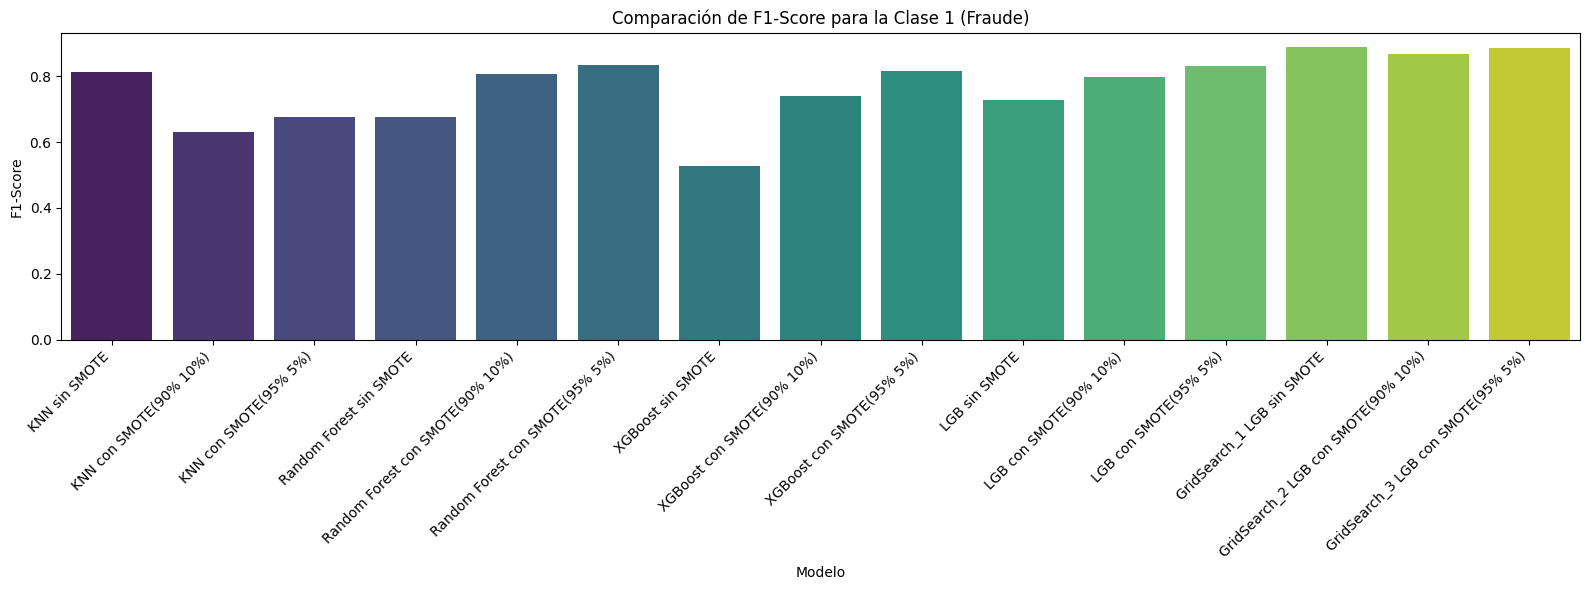

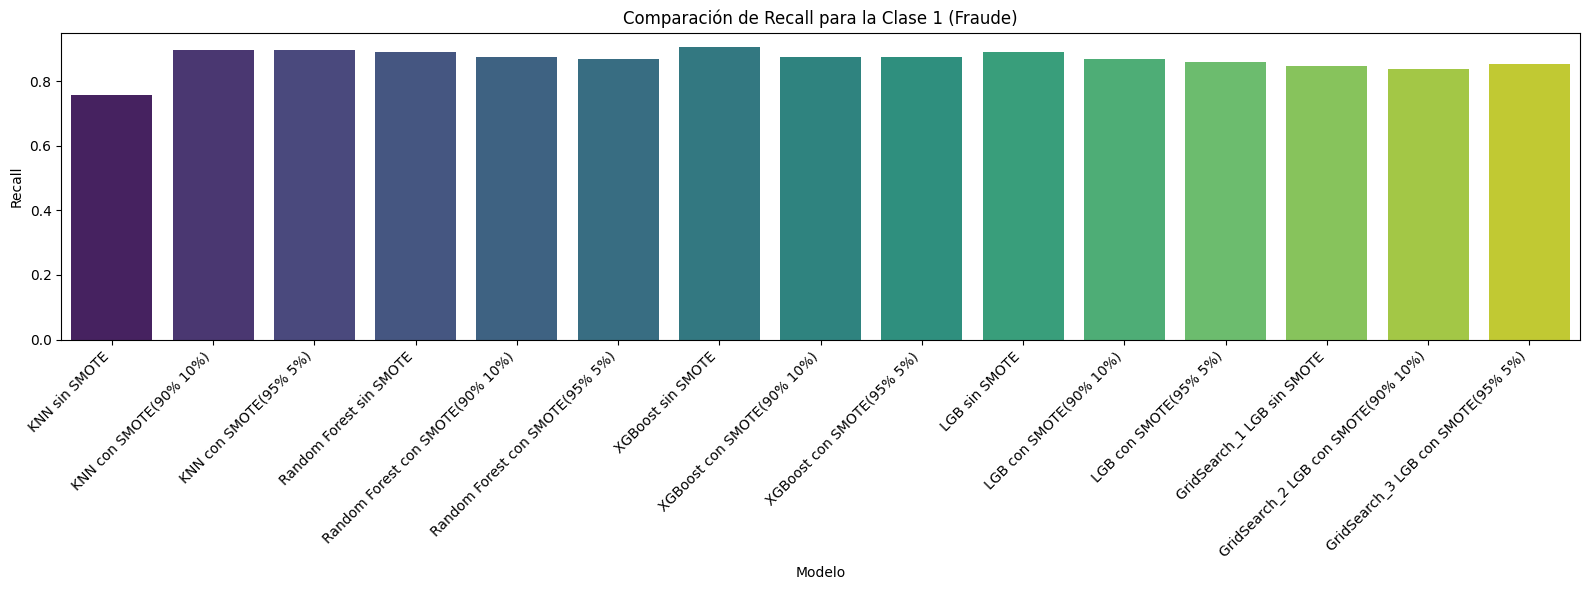

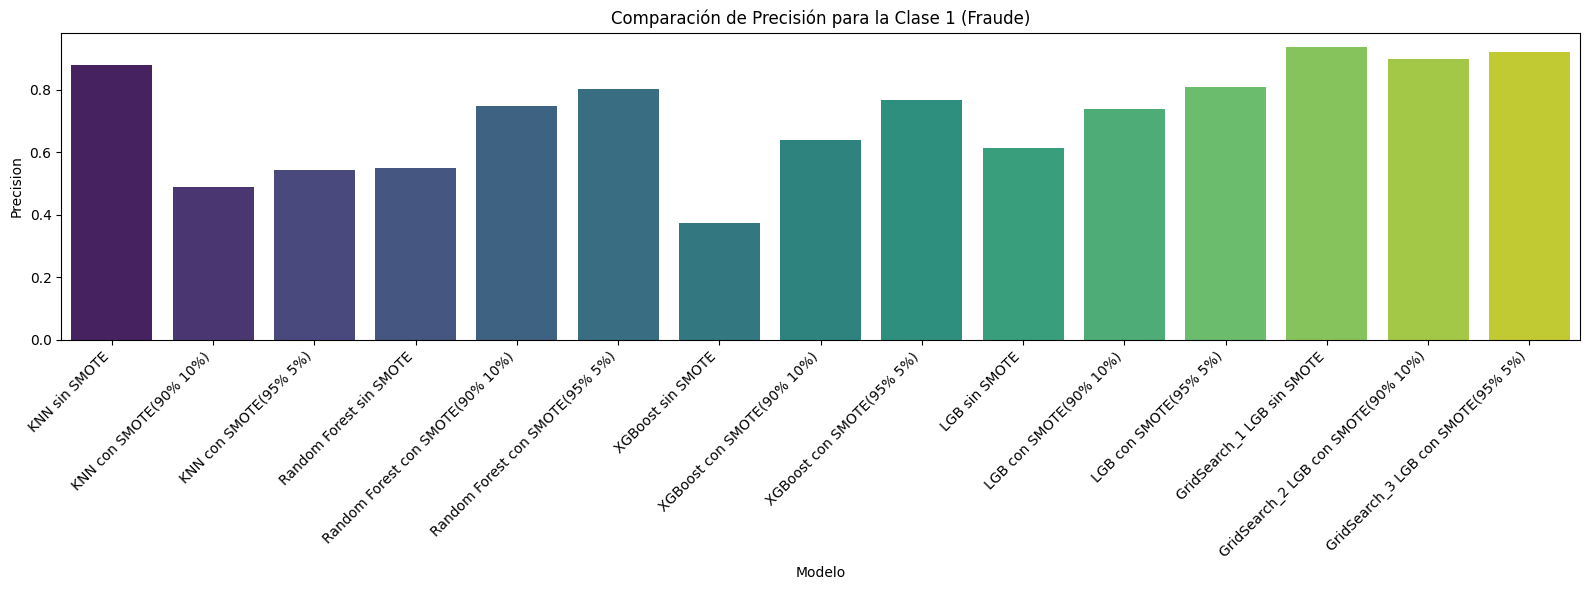

In [ ]:
# F1-Score
plt.figure(figsize=(16, 6))
sns.barplot(data=comparacion_modelos_por_clase, x='Modelo', y='F1-Score', palette='viridis')
plt.title('Comparación de F1-Score para la Clase 1 (Fraude)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Recall
plt.figure(figsize=(16, 6))
sns.barplot(data=comparacion_modelos_por_clase, x='Modelo', y='Recall', palette='viridis')
plt.title('Comparación de Recall para la Clase 1 (Fraude)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Precisión
plt.figure(figsize=(16, 6))
sns.barplot(data=comparacion_modelos_por_clase, x='Modelo', y='Precision', palette='viridis')
plt.title('Comparación de Precisión para la Clase 1 (Fraude)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Análisis Visual de Modelos: Gráficas Comparativas

**Análisis de Recall**

La gráfica de recall revela el comportamiento de los modelos respecto a su **capacidad para detectar fraudes** (minimizar falsos negativos):

* Los modelos sin SMOTE tienden a presentar **ligeros descensos en recall**, lo cual es esperable debido al desbalance de clases.
* El **uso de SMOTE mejora claramente el recall en KNN**.
* La mayoría de los modelos se sitúan por encima de 0.8, lo que indica una recuperación estable para la mayoría de los modelos con SMOTE.

**Análisis de F1-Score**

Esta gráfica resume el **balance entre precisión y recall**, reflejando la capacidad general del modelo para **mantener buen rendimiento frente a ambas métricas**:

* Destacan varios modelos por encima de 0.8, lo que refuerza su rendimiento integral.
* El **uso de SMOTE beneficia claramente a Random Forest, XGBoost y LGBM**, mejorando su F1-score respecto a sus versiones sin rebalanceo.
* Por otro lado, **KNN muestra una caída progresiva en F1-score con SMOTE**, lo que sugiere que este algoritmo es más sensible a la generación sintética de ejemplos.

#### Análisis de Precisión

La precisión evalúa la proporción de predicciones positivas que realmente son fraudes (minimizar falsos positivos):

* **KNN sin SMOTE** lidera esta métrica, aunque con menor recall, lo que confirma su comportamiento conservador.
* Los **modelos GridSearch de LGBM** sobresalen por mantener alta precisión sin sacrificar demasiado el recall, lo que explica sus buenos F1-scores.
* En cambio, **XGBoost sin SMOTE** muestra un punto crítico: bajo valor de precisión, asociado a un número alto de falsos positivos, a pesar de tener un alto recall.
* El **rebalanceo con SMOTE mejora notablemente la precisión en XGBoost y Random Forest**, ubicándolos más cerca de los modelos óptimos.

### Matriz de confusion y demas gráficas

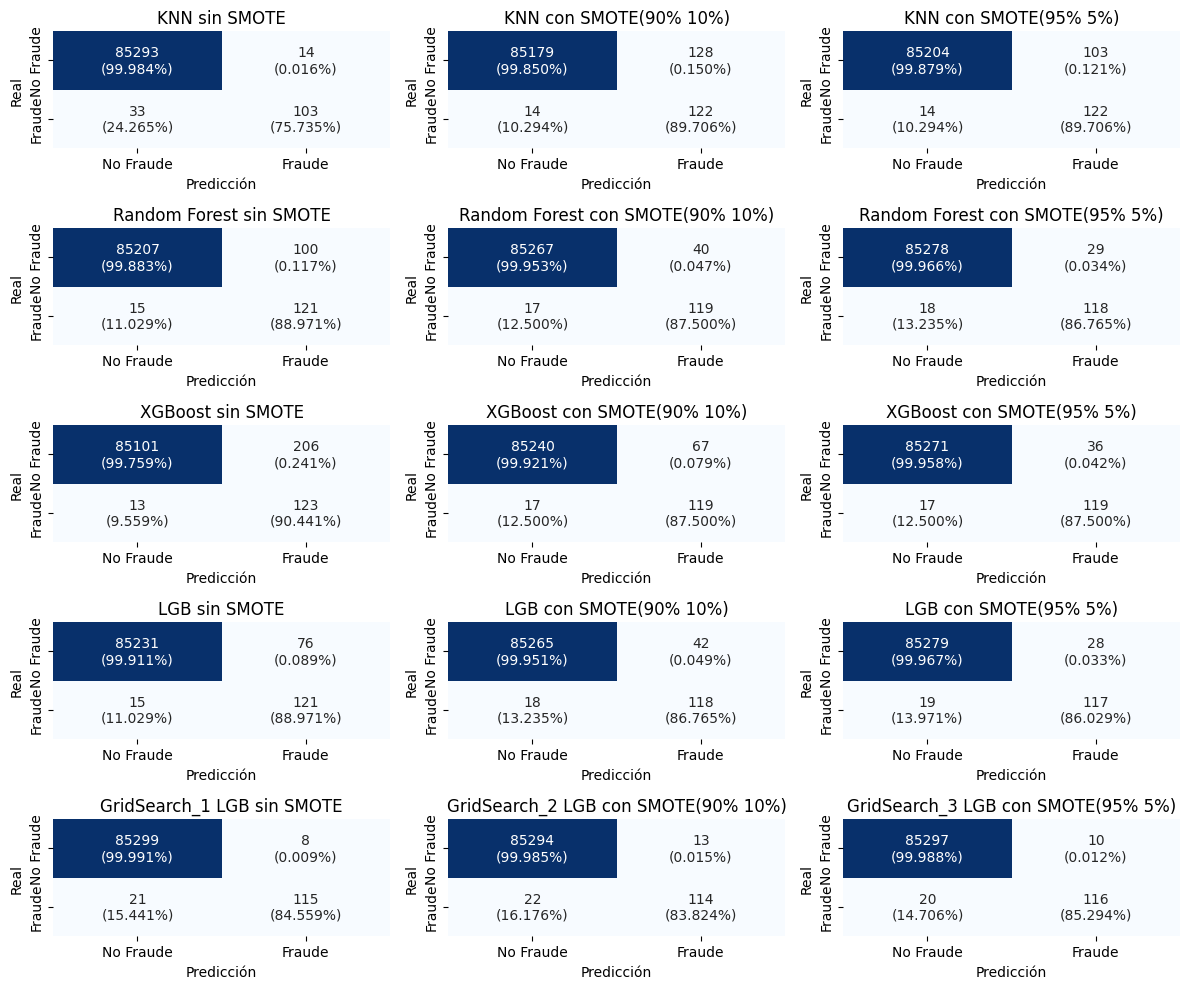

In [ ]:
# Colocar en porcentaje las matrices de confusion
def plot_confusion_matrix_from_preds(models, y_test, resultados_pred, figsize=(12, 10)):
    n = len(models)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.ravel()

    labels = ['No Fraude', 'Fraude']

    for i, (model_name, _) in enumerate(models):
        y_pred = resultados_pred[model_name]
        cm = confusion_matrix(y_test, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Anotaciones: número absoluto + porcentaje
        annot = np.empty_like(cm).astype(str)
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                annot[r, c] = f"{cm[r, c]}\n({cm_percent[r, c]:.3f}%)"

        sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[i],
                    xticklabels=labels, yticklabels=labels, cbar=False)
        axes[i].set_title(model_name)
        axes[i].set_xlabel("Predicción")
        axes[i].set_ylabel("Real")

    # Oculta los ejes no utilizados
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_confusion_matrix_from_preds(models, y_test, resultados_pred)

### Análisis de las Matrices de Confusión

Las matrices de confusión permiten analizar con detalle la calidad de las predicciones en términos de aciertos y errores, enfocándose en la clase **1 (fraude)**. Resultan especialmente útiles para evaluar los **falsos negativos** (fraudes no detectados) y **falsos positivos** (transacciones legítimas clasificadas erróneamente como fraude), aspectos críticos en contextos financieros.

Cada celda muestra tanto el **valor absoluto** como su **porcentaje respecto a la clase real**, lo cual aporta interpretabilidad en un escenario de **desbalance extremo**. A continuación, se describen los hallazgos más relevantes por grupo de modelos:

#### Modelos KNN

* **KNN sin SMOTE** identifica correctamente el **75.7 %** de los fraudes (103/136), incurriendo en un **24.3 % de falsos negativos**, con apenas un **0.016 % de falsos positivos**. Este balance le permite alcanzar un F1-score competitivo, demostrando que **funciona bien sin rebalanceo**.
* En contraste, **KNN con SMOTE (90%-10% y 95%-5%)** reduce los falsos negativos a aproximadamente **10.3 %**, pero **incrementa notoriamente los falsos positivos** (0.15 % y 0.12 %). Esto penaliza fuertemente la precisión, evidenciando que **KNN es sensible a SMOTE**, especialmente sin ajuste fino.

#### Modelos Random Forest

* **Random Forest sin SMOTE** detecta **el 89.0 % de los fraudes**, pero introduce **100 falsos positivos**, lo cual deteriora su precisión.
* Al aplicar **SMOTE**, los falsos positivos se reducen drásticamente a **40 y 29**, manteniendo un **recall entre 87.5 % y 86.8 %**. El modelo con **SMOTE 95%-5%** logra el **mejor equilibrio**, reduciendo falsos positivos sin comprometer la detección de fraudes.

#### Modelos XGBoost

* **XGBoost sin SMOTE** presenta un alto recall (**90.4 %**) con apenas **13 falsos negativos**, pero a costa de **206 falsos positivos**, lo que genera una baja precisión.
* Con **SMOTE (90%-10% y 95%-5%)**, los falsos positivos se reducen significativamente (**67 y 36**), mientras que el recall se mantiene en **87.5 %**, mostrando una mejora sustancial del equilibrio entre sensibilidad y especificidad.

#### Modelos LightGBM

* **LGB sin SMOTE** logra una recuperación del **89.0 %**, con **15 falsos negativos** y **76 falsos positivos**, lo que lo ubica entre los mejores modelos base sin ajuste.
* Las variantes con **SMOTE (90%-10% y 95%-5%)** mantienen un rendimiento estable en recall (**86.8 % y 86.0 %**) y reducen los falsos positivos a **42 y 28**, mejorando así la precisión.
* No obstante, los **mejores resultados globales** provienen de los modelos con **GridSearch**:

  * **GridSearch\_1 LGB sin SMOTE** detecta **115 fraudes (84.6 %)** con solo **8 falsos positivos (0.009 %)**, lo que representa un modelo **altamente preciso y balanceado**.
  * **GridSearch\_3 LGB con SMOTE (95%-5%)** identifica **116 fraudes (85.3 %)** y mantiene **10 falsos positivos**, evidenciando un rendimiento muy competitivo incluso con rebalanceo.

### Conclusión

Las matrices de confusión **respaldan y contextualizan los resultados cuantitativos previos**: los modelos con mayor F1-score también son los que mejor **minimizan errores críticos de clasificación**, tanto en recall como en precisión.

* **GridSearch\_1 LGB sin SMOTE** y **GridSearch\_3 LGB con SMOTE (95%-5%)** se posicionan como los modelos **más robustos y confiables**.
* **SMOTE mejora notablemente modelos como XGBoost y Random Forest**, siempre que se utilice con proporciones adecuadas (como 95%-5 %).
* En cambio, **KNN tiende a degradarse con SMOTE**, generando muchos más falsos positivos, por lo que su uso debe ser cuidadosamente calibrado.
* Finalmente, el uso de **porcentajes en las matrices** facilita una evaluación más justa en contextos de desbalance, permitiendo comparar modelos más allá de los valores absolutos y enfocarse en su **comportamiento proporcional dentro de cada clase**.

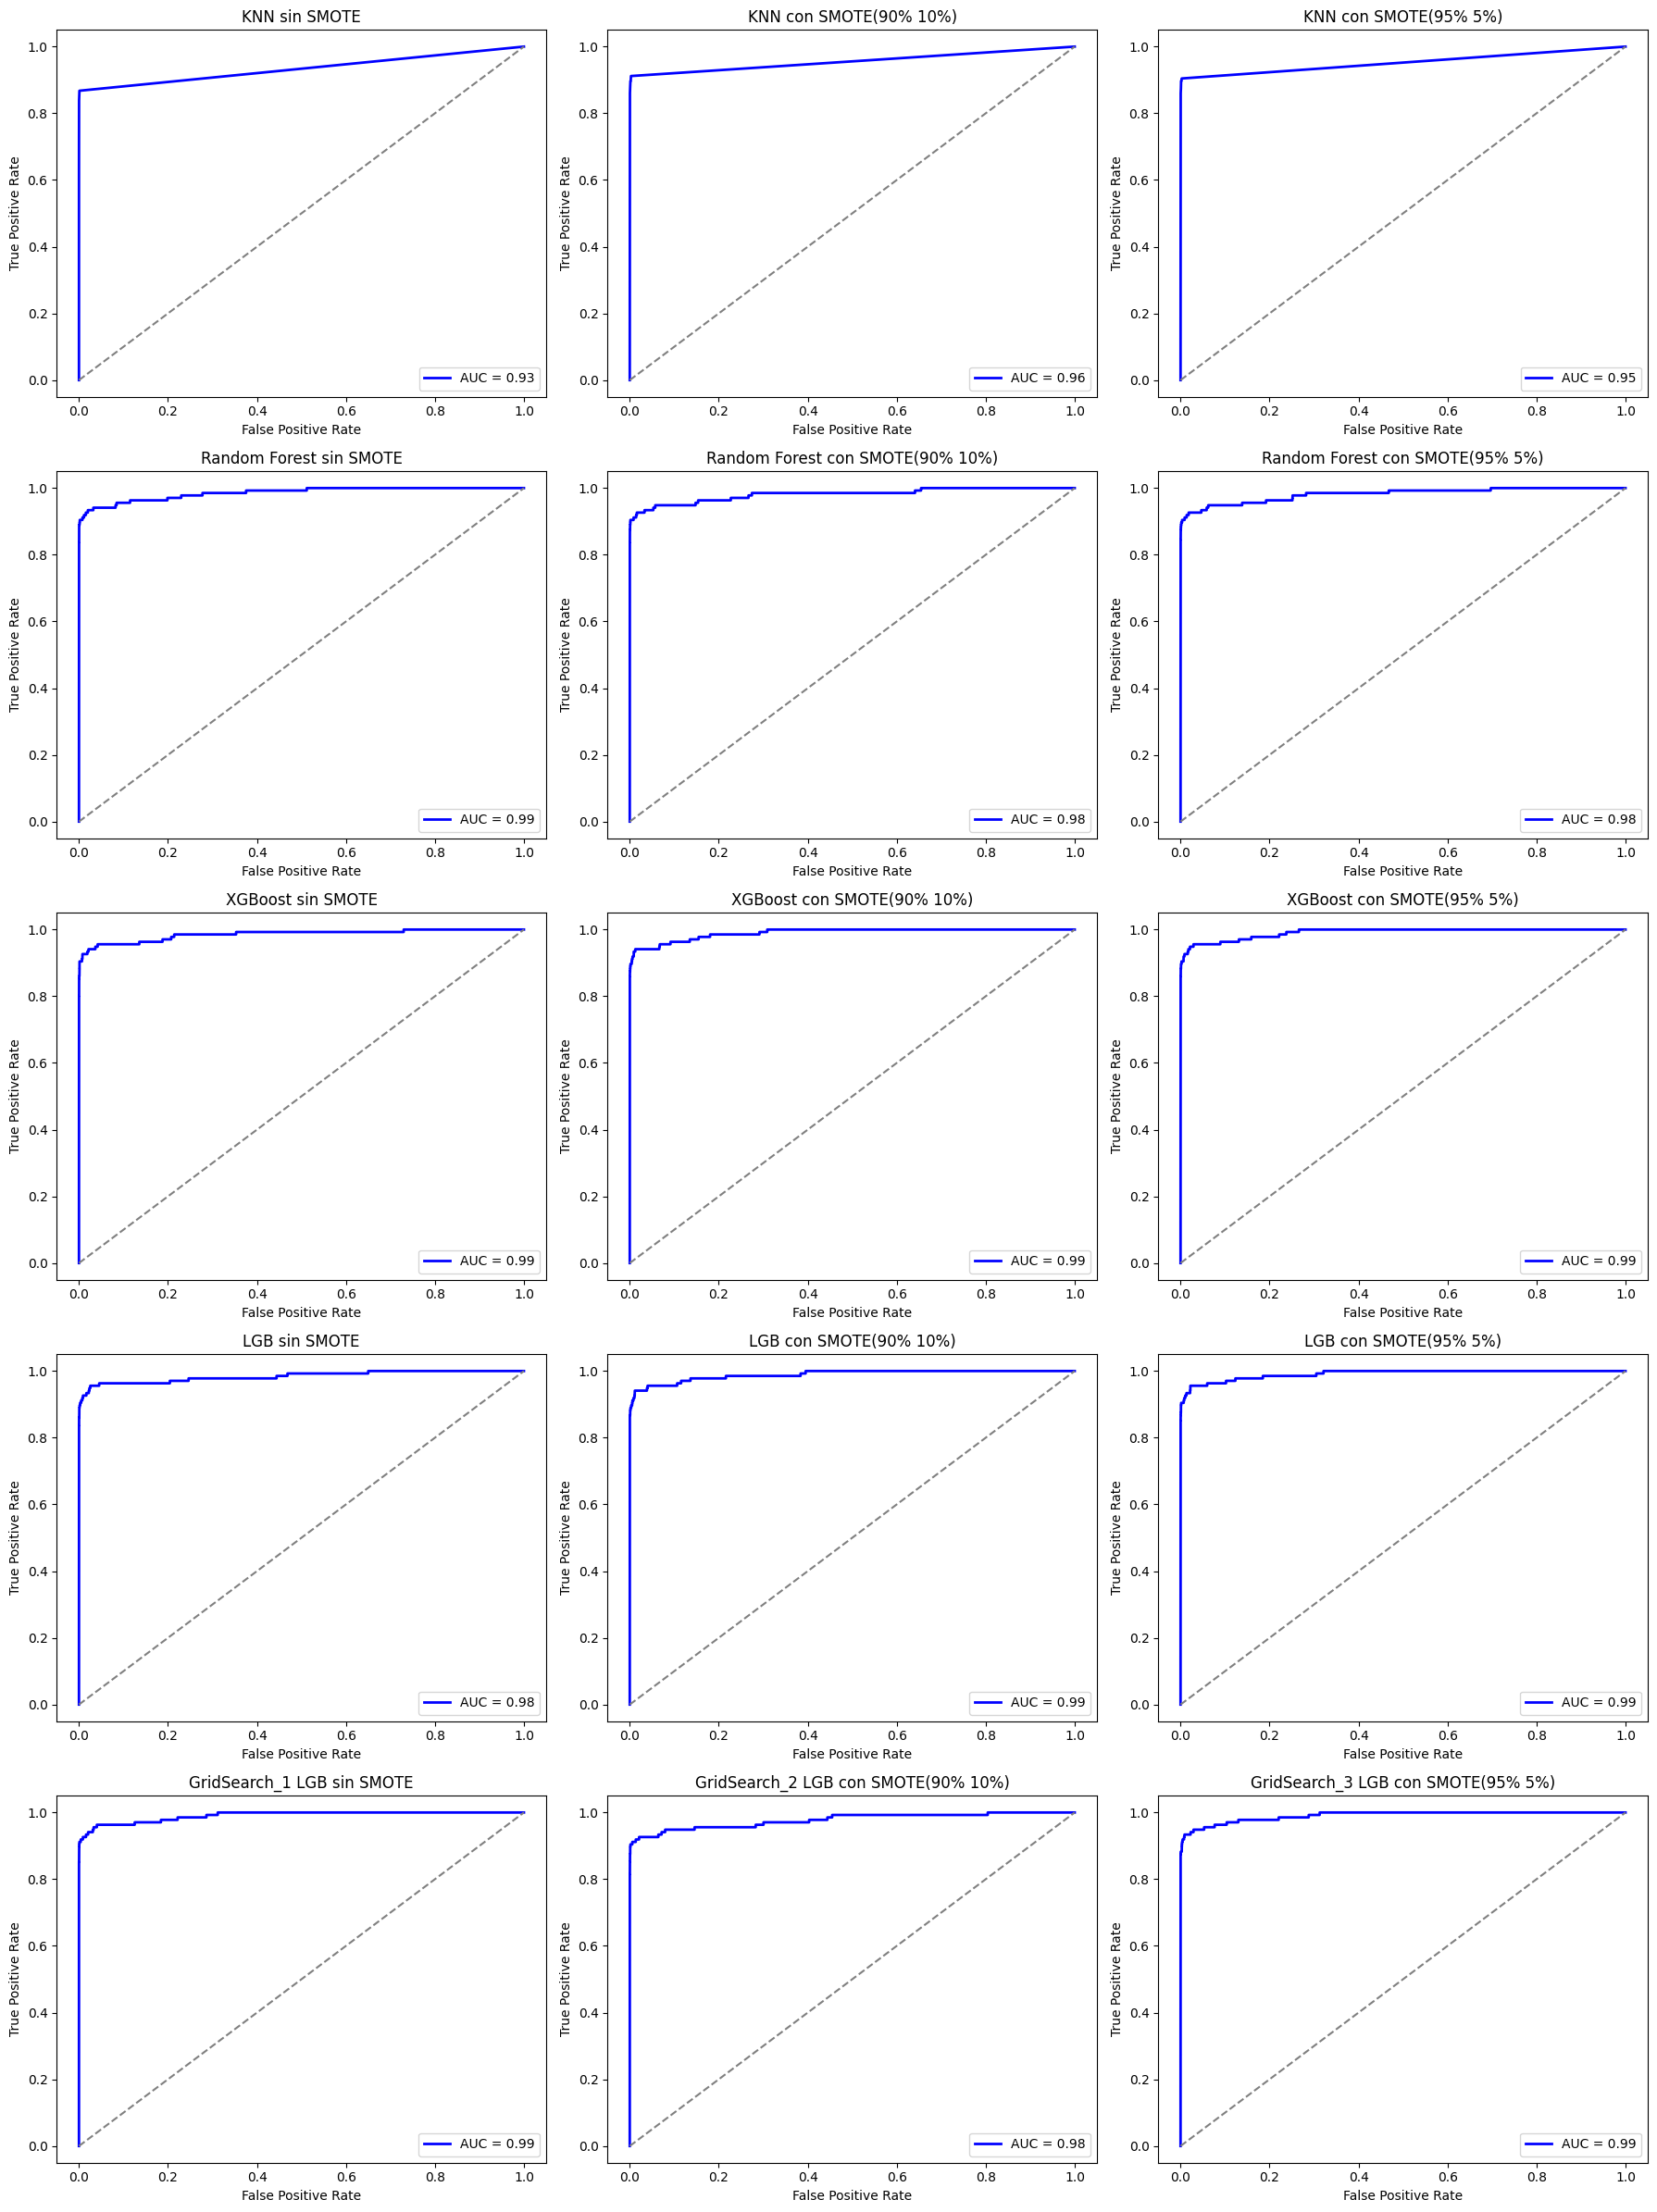

In [ ]:
def plot_roc_curve(models, X_test, y_test, titles):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models):
        try:
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                continue  # No se puede calcular ROC

            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            axes[idx].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
            axes[idx].plot([0, 1], [0, 1], color='gray', linestyle='--')
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel('False Positive Rate')
            axes[idx].set_ylabel('True Positive Rate')
            axes[idx].legend(loc='lower right')
        except Exception as e:
            print(f"Error en modelo {name}: {e}")
            fig.delaxes(axes[idx])

    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_roc_curve(models, X_test, y_test, titles)

### Análisis de la Curva ROC

Las curvas **ROC** permiten evaluar visualmente la capacidad de los modelos para **discriminar entre clases**, observando la relación entre la tasa de verdaderos positivos (*TPR*) y la tasa de falsos positivos (*FPR*). La **área bajo la curva (AUC)** sintetiza esta capacidad: un valor cercano a 1 indica una excelente discriminación, mientras que un valor cercano a 0.5 representa un comportamiento aleatorio.

#### Observaciones Clave

* **Todos los modelos presentan valores de AUC elevados**, entre **0.93 y 0.99**, lo que indica una **alta capacidad para diferenciar fraudes de transacciones legítimas**.
* El modelo **KNN sin SMOTE**  alcanza un AUC de **0.93**, mientras que sus variantes con SMOTE mejoran ligeramente hasta 0.96 y 0.95, respectivamente.
* **Random Forest, XGBoost y LightGBM**, tanto en versiones base como con SMOTE, mantienen un **AUC de 0.98 y 0.99**, lo que confirma su **alta capacidad discriminativa**, incluso en presencia de datos rebalanceados
* Los modelos **GridSearch optimizados de LightGBM** no solo conservan el AUC = 0.99, sino que también logran mantener buenas métricas de precisión y recall, lo cual valida su **excelente capacidad de generalización**.

#### Interpretación del AUC

* Un valor de **AUC = 0.99** implica que el modelo clasificará correctamente una instancia de fraude como más probable que una legítima en el **99 % de los casos**.
* No obstante, el AUC **no refleja directamente el balance entre precisión y recall**, por lo que debe complementarse con métricas como el **F1-score** y la **matriz de confusión** para una evaluación más completa del modelo.

### Conclusión

* **XGBoost y LightGBM** son los modelos con **mejores curvas ROC**, manteniendo **AUC = 0.99** de manera consistente en todas las variantes, incluso al aplicar SMOTE.
* **KNN**, aunque logra un AUC decente (**0.93**), se muestra **menos eficaz al modelar patrones complejos**, por lo que es más adecuado en contextos simples o cuando se requiere rapidez sobre precisión.
* El **alto y estable valor del AUC en LightGBM**, incluso con técnicas de rebalanceo y optimización de hiperparámetros, lo posiciona como el **modelo más confiable y robusto** para sistemas de detección de fraudes en este estudio.

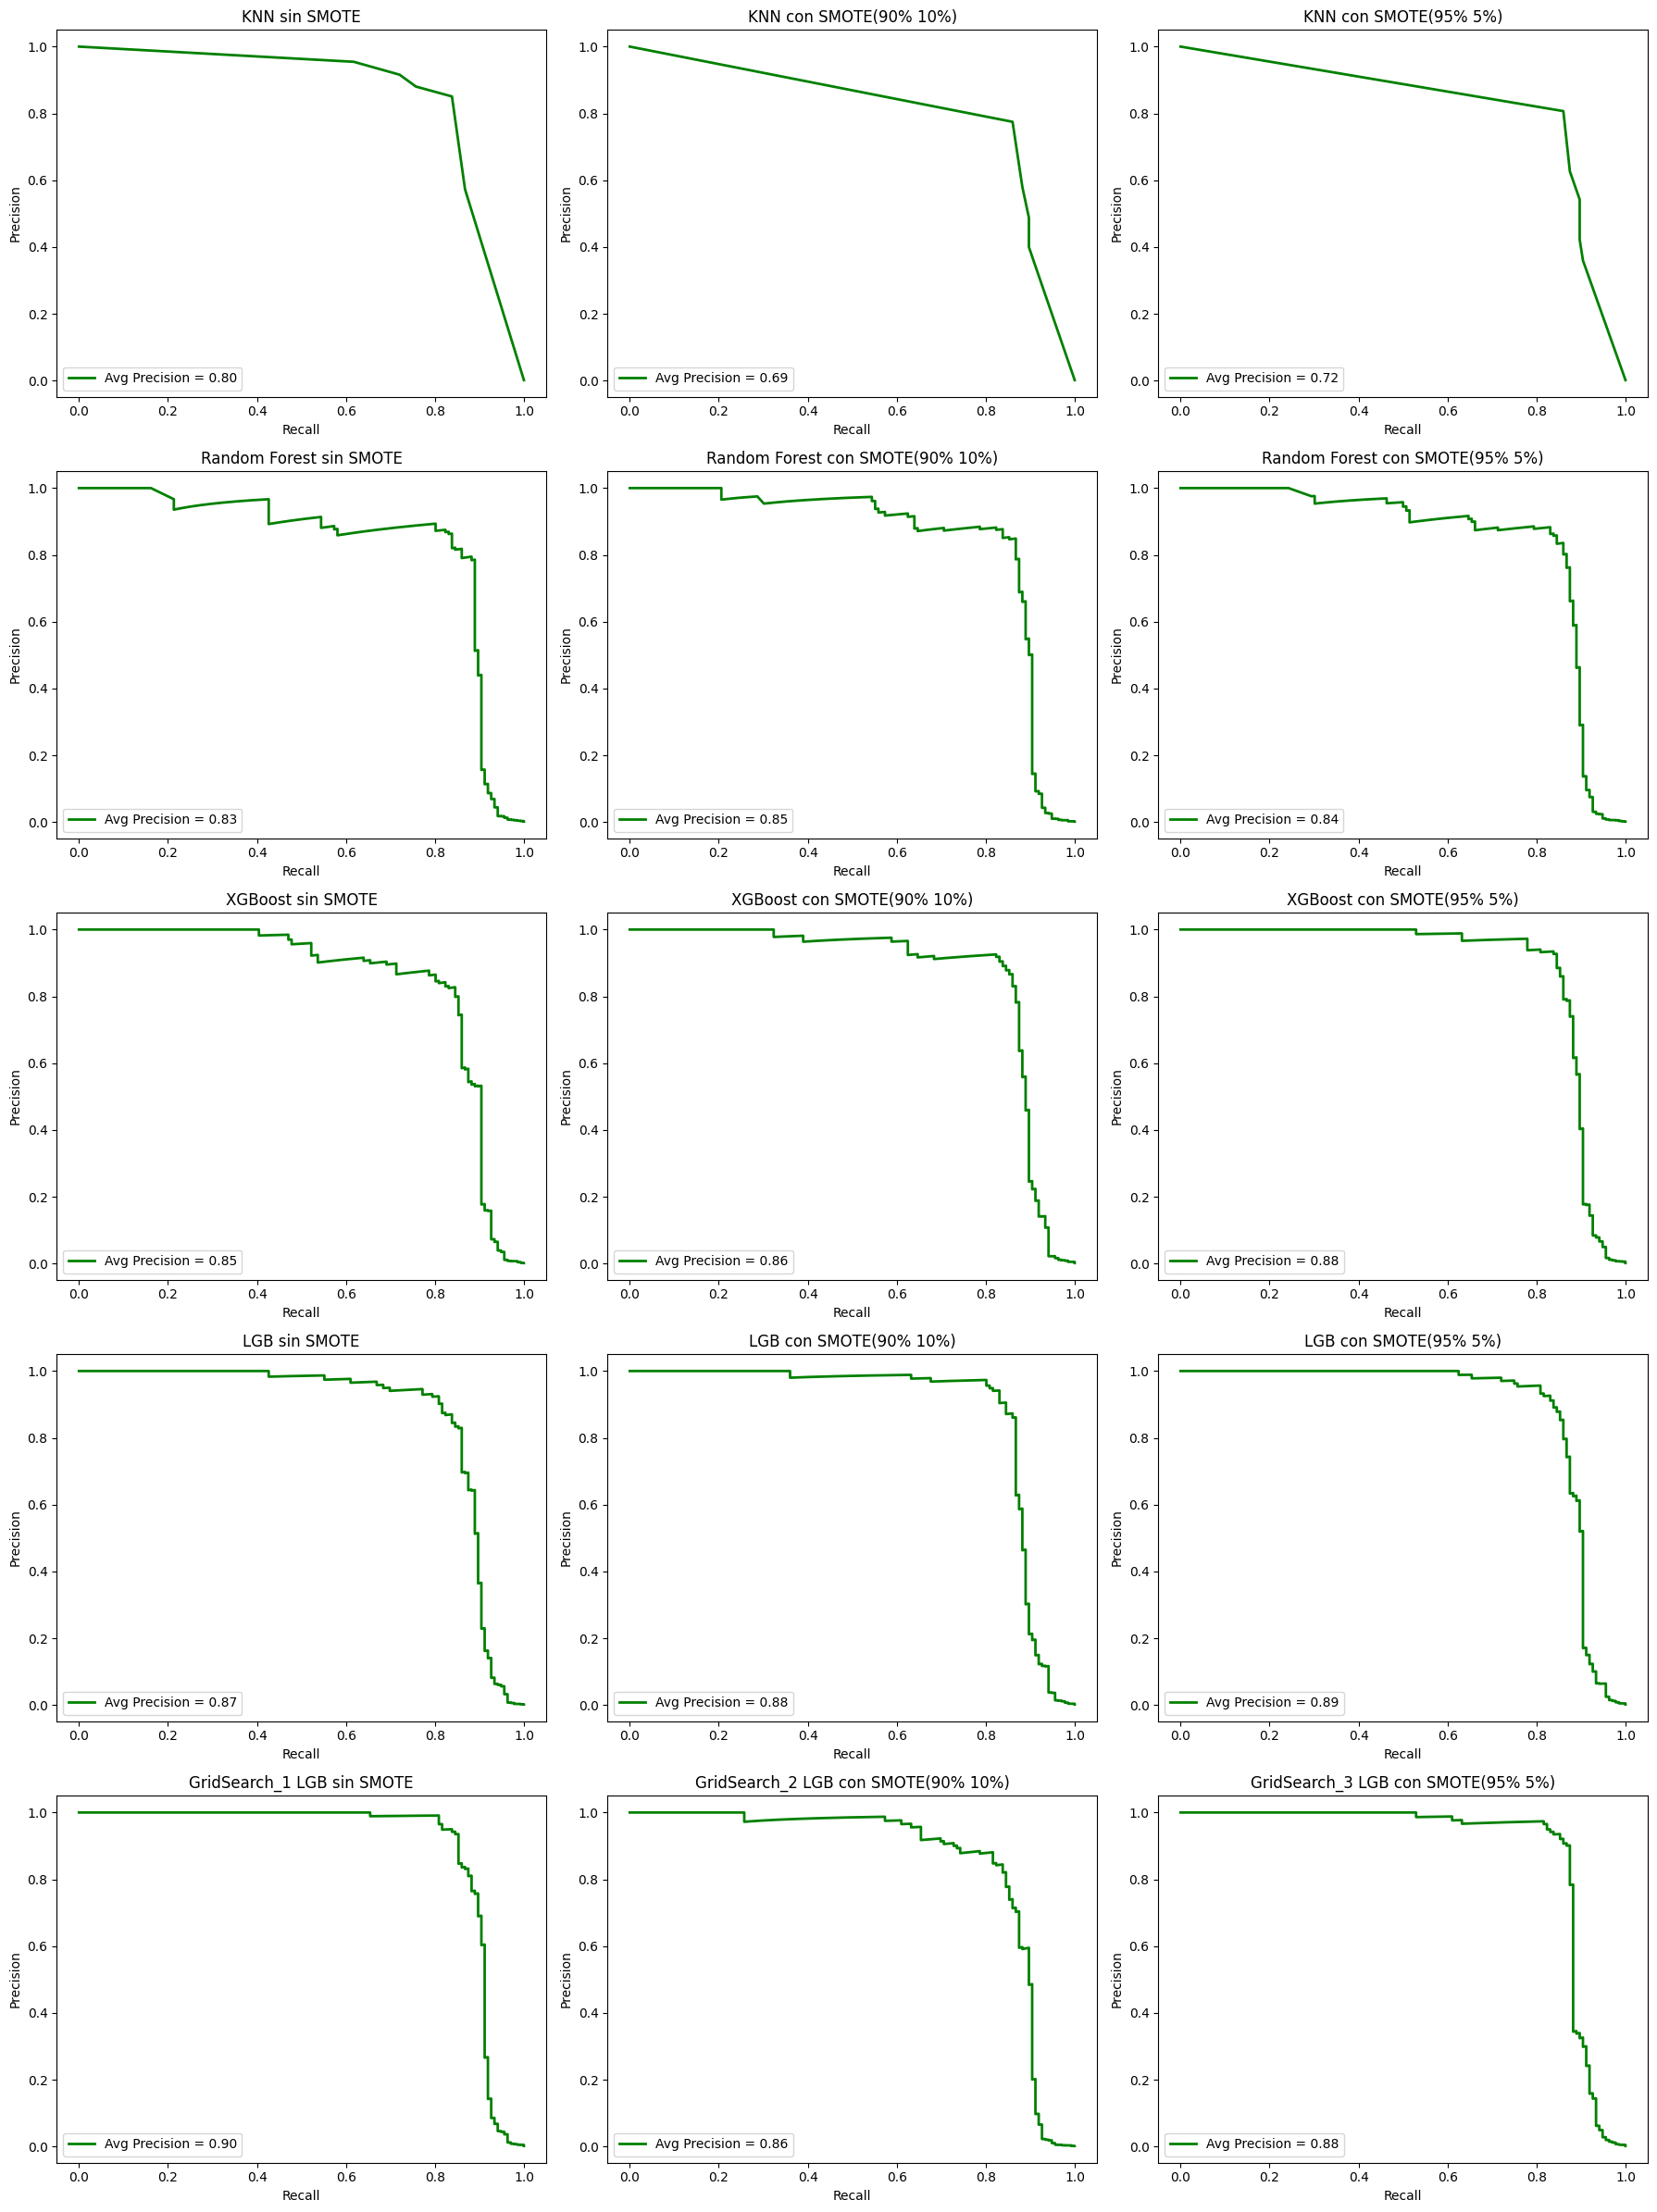

In [ ]:
def plot_precision_recall_curve(models, X_test, y_test, titles):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 24))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models):
        try:
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                continue  # No se puede calcular PR

            precision, recall, _ = precision_recall_curve(y_test, y_score)
            avg_precision = average_precision_score(y_test, y_score)

            axes[idx].plot(recall, precision, color='green', lw=2, label=f'Avg Precision = {avg_precision:.2f}')
            axes[idx].set_title(titles[idx])
            axes[idx].set_xlabel('Recall')
            axes[idx].set_ylabel('Precision')
            axes[idx].legend(loc='lower left')
        except Exception as e:
            print(f"Error en modelo {name}: {e}")
            fig.delaxes(axes[idx])

    for i in range(len(models), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

plot_precision_recall_curve(models, X_test, y_test, titles)

### Análisis de la Curva de Precisión-Recall

La curva de **Precisión-Recall** es especialmente útil en escenarios con **clases desbalanceadas**, como en la detección de fraudes, ya que pone el foco en el comportamiento de la clase positiva (fraude) sin verse influenciada por la abundancia de casos negativos.

Esta curva muestra la relación entre:

* **Precisión**: proporción de verdaderos positivos sobre las predicciones positivas.
* **Recall**: proporción de verdaderos positivos sobre los casos reales de fraude.

El área bajo esta curva (**AP, Average Precision**) resume el rendimiento del modelo a lo largo de todos los umbrales de decisión. Cuanto más alto el AP, **mejor es la capacidad del modelo para mantener alta precisión mientras aumenta el recall**.

#### Observaciones Clave

* Los modelos **LightGBM optimizados con Grid Search** (sin SMOTE y con SMOTE en proporciones 90%-10% y 95%-5%) logran los **mejores valores de AP (0.86–0.90)**, lo que confirma su **excelente capacidad para balancear precisión y cobertura** en todas las regiones del umbral.

* Les siguen los modelos **LightGBM base** y **XGBoost con SMOTE**, con AP entre **0.85 y 0.89**, lo que indica una **respuesta sólida y estable incluso tras el rebalanceo**.

* Los modelos **Random Forest sin SMOTE (AP = 0.83)** y **XGBoost sin SMOTE (AP = 0.85)** muestran un rendimiento decente, pero claramente se ven mejorados por el uso de SMOTE.

* En contraste, **KNN con SMOTE** presenta un **descenso significativo en AP** (0.69 y 0.72) respecto a su versión sin rebalanceo (0.80), lo cual sugiere que **este algoritmo es especialmente sensible a la generación sintética de ejemplos**, posiblemente debido a su dependencia de distancias en un espacio afectado por el rebalanceo.

### Conclusión

La curva Precision-Recall **refuerza la superioridad de los modelos LightGBM ajustados con Grid Search**, capaces de mantener una **alta precisión y cobertura en todo el rango de clasificación**. Les siguen de cerca los modelos **XGBoost con SMOTE**, que muestran mejoras claras frente a su versión sin rebalanceo. En cambio, **KNN y, en menor medida, Random Forest**, evidencian **una pérdida de precisión tras aplicar SMOTE**, lo que limita su aplicabilidad en contextos donde se busca reducir falsos positivos sin sacrificar recall.


### Soft voting

In [ ]:
# Lista con los nombres de los modelos base para el soft voting
base_models_t = ['KNN sin SMOTE',
                 'Random Forest con SMOTE(95% 5%)',
                 'XGBoost con SMOTE(95% 5%)']

In [ ]:
# Diccionario con los modelos base para el soft voting
clftsgrid = {
    'KNN sin SMOTE': model_knn,
    'Random Forest con SMOTE(95% 5%)': model_rf_smote_5,
    'XGBoost con SMOTE(95% 5%)': model_xgb_smote_5
}

In [ ]:
# Construcción del ensemble con pesos (ajustar si hace sentido)
voting_clf = VotingClassifier(
    estimators=[(name, clftsgrid[name]) for name in base_models_t],
    voting='soft',
    weights=[8.1, 8.3, 8.2]) # KNN sin SMOTE con 0.81, Random Forest con SMOTE(95% 5%) con 0.83, XGBoost con SMOTE(95% 5%) con 0.82

# Entrenamiento y predicción
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)

# Evaluación
print("Accuracy:", voting_clf.score(X_test, y_test))

Accuracy: 0.9995903701883126


In [ ]:
# guardar el voting
joblib.dump(voting_clf, '/content/drive/MyDrive/Master/voting_clf.joblib')

['/content/drive/MyDrive/Master/voting_clf.joblib']

In [ ]:
# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred_voting))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.81      0.86       136

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
precision = precision_score(y_test, y_pred_voting, pos_label=1)
recall = recall_score(y_test, y_pred_voting, pos_label=1)
f1 = f1_score(y_test, y_pred_voting, pos_label=1)

print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")

Precision: 0.924370
Recall: 0.808824
F1-Score: 0.862745


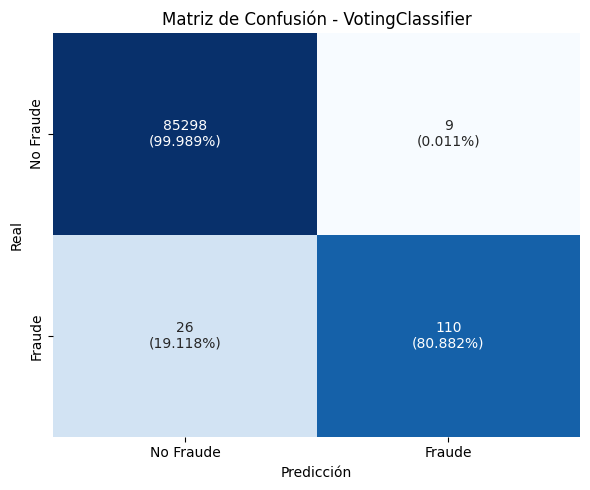

In [ ]:
# Matriz de confusión y porcentajes
cm = confusion_matrix(y_test, y_pred_voting)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Anotaciones combinadas: número + porcentaje
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.3f}%)"

# Etiquetas
labels = ['No Fraude', 'Fraude']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=annot, fmt='', cmap='Blues',
            xticklabels=labels, yticklabels=labels, vmin=0, vmax=100, cbar=False)
plt.title("Matriz de Confusión - VotingClassifier")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

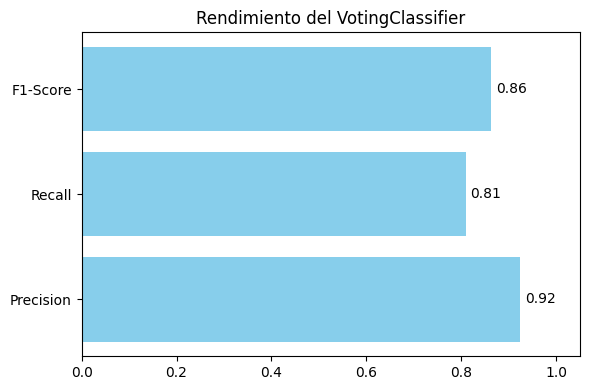

In [ ]:
# Datos
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.barh(metrics, scores, color='skyblue')
plt.xlim(0, 1.05)  # Extiende el límite del eje X un poco más allá de 1

plt.title("Rendimiento del VotingClassifier")

for bar, score in zip(bars, scores):
    # Si el score está cerca de 1, coloca el texto dentro de la barra
    if score > 0.94:
        plt.text(score - 0.05, bar.get_y() + bar.get_height()/2, f"{score:.2f}",
                 va='center', ha='right', color='white', fontweight='bold')
    else:
        plt.text(score + 0.01, bar.get_y() + bar.get_height()/2, f"{score:.2f}",
                 va='center')

plt.tight_layout()
plt.show()

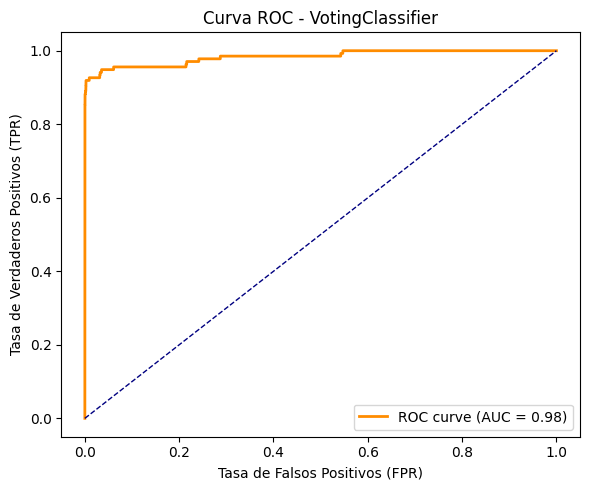

In [ ]:
# Obtener las probabilidades del modelo VotingClassifier
y_score_voting = voting_clf.predict_proba(X_test)[:, 1]

# Calcular FPR, TPR y AUC
fpr, tpr, _ = roc_curve(y_test, y_score_voting)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - VotingClassifier')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

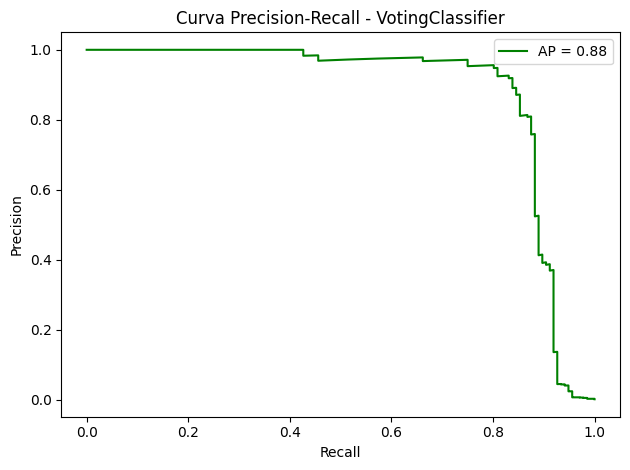

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_score_voting)
avg_precision = average_precision_score(y_test, y_score_voting)

plt.figure()
plt.plot(recall_vals, precision_vals, color='green', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - VotingClassifier')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### Evaluación del Modelo Ensemble — Voting Classifier

Como estrategia de mejora, se diseñó un clasificador ensemble utilizando la técnica de **Voting Classifier con votación soft**, combinando tres de los modelos individuales con mejor desempeño (excluyendo a LightGBM):

* **KNN sin SMOTE**
* **Random Forest con SMOTE (95%-5%)**
* **XGBoost con SMOTE (95%-5%)**

Los pesos asignados fueron proporcionales a su F1-score individual (KNN = 0.81, RF = 0.83, XGB = 0.82), permitiendo así una combinación ponderada más representativa. La votación *soft*, al basarse en las probabilidades de clase, proporciona una integración más precisa que la votación *hard*.

#### Resultados del Voting Classifier

El modelo VotingClassifier alcanzó métricas altamente competitivas en la clase minoritaria (fraude):

* **Precisión**: 0.924
* **Recall**: 0.809
* **F1-score**: 0.863
* **AUC (ROC)**: 0.98
* **AP (Average Precision)**: 0.88
* **Exactitud general**: 99.96 %

#### Análisis de la Matriz de Confusión

La matriz de confusión evidencia una clasificación muy precisa:

* Se identificaron correctamente **110 fraudes reales**, lo que representa el **80.9 %** de los casos positivos.
* Solo se incurrió en **26 falsos negativos** (19.1 %).
* Para la clase mayoritaria, se alcanzó una **exactitud del 99.99 %**, con apenas **9 falsos positivos**.

Este comportamiento refleja un adecuado equilibrio entre **sensibilidad y especificidad**, con un coste mínimo en precisión.

#### Análisis de las Curvas ROC y PR

* La **curva ROC** presenta una trayectoria muy próxima al vértice superior izquierdo, con **AUC = 0.98**, lo que denota una **alta capacidad discriminativa**, incluso con umbrales conservadores.

* La **curva de Precisión-Recall** muestra:

  * Una **meseta prolongada de alta precisión**, incluso en niveles elevados de recall, lo que indica **robustez frente al ruido**.
  * Un **descenso abrupto final**, señal de que el modelo **distingue claramente los casos más ambiguos**, sin confundirlos con la clase negativa.

#### Comparación con el Mejor Modelo Individual

El modelo **GridSearch\_1\_LGB sin SMOTE** fue identificado previamente como el mejor clasificador individual:

| Modelo                  | Precisión | Recall | F1-score |
| ----------------------- | --------- | ------ | -------- |
| GridSearch\_1 LGB       | 0.935     | 0.846  | 0.888    |
| VotingClassifier (Soft) | 0.924     | 0.809  | 0.863    |

Ambos modelos presentan valores de F1-score similares, pero con diferencias estratégicas:

* El **VotingClassifier** ofrece **mayor precisión**, con menor tasa de falsos positivos, ideal en contextos donde se requiere reducir las alarmas injustificadas.
* El modelo **LightGBM optimizado**, en cambio, alcanza **mayor recall**, lo que lo hace más adecuado para maximizar la cobertura de fraudes reales.

### Conclusión Final

El VotingClassifier constituye una estrategia válida y eficaz para combinar modelos complementarios, logrando:

* **Alta precisión** y **elevados valores de AUC y AP**.
* **Baja tasa de falsos positivos**, favoreciendo su uso en entornos donde las alertas erróneas son costosas.

No obstante:

* **No supera sistemáticamente** al mejor modelo individual, que sigue siendo **LightGBM optimizado con Grid Search**.
* Se recomienda mantener este último como la **propuesta principal de implementación**, sobre todo en aplicaciones donde se prioriza la **detección exhaustiva de fraudes** (alto recall).
* El VotingClassifier queda documentado como una **alternativa sólida y con potencial de despliegue**, especialmente útil en contextos donde se valora más la **confiabilidad de las predicciones positivas**.